In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# import everything we need first
from keras import utils
import numpy as np
from sklearn.model_selection import train_test_split
import pylab as plt



#from astroNN.models import Galaxy10CNN
#from astroNN.datasets import galaxy10
#from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion


In [8]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

In [3]:
labelname=["Smooth, Completely round",
"Smooth, in-between round",
"Smooth, Cigar shaped",
"Disk, Edge-on, Rounded Bulge",
"Disk, Edge-on, Boxy Bulge",
" Disk, Edge-on, No Bulge",
" Disk, Face-on, Tight Spiral",
" Disk, Face-on, Medium Spiral",
"Disk, Face-on, Loose Spiral"]

===================Data Inspection===================


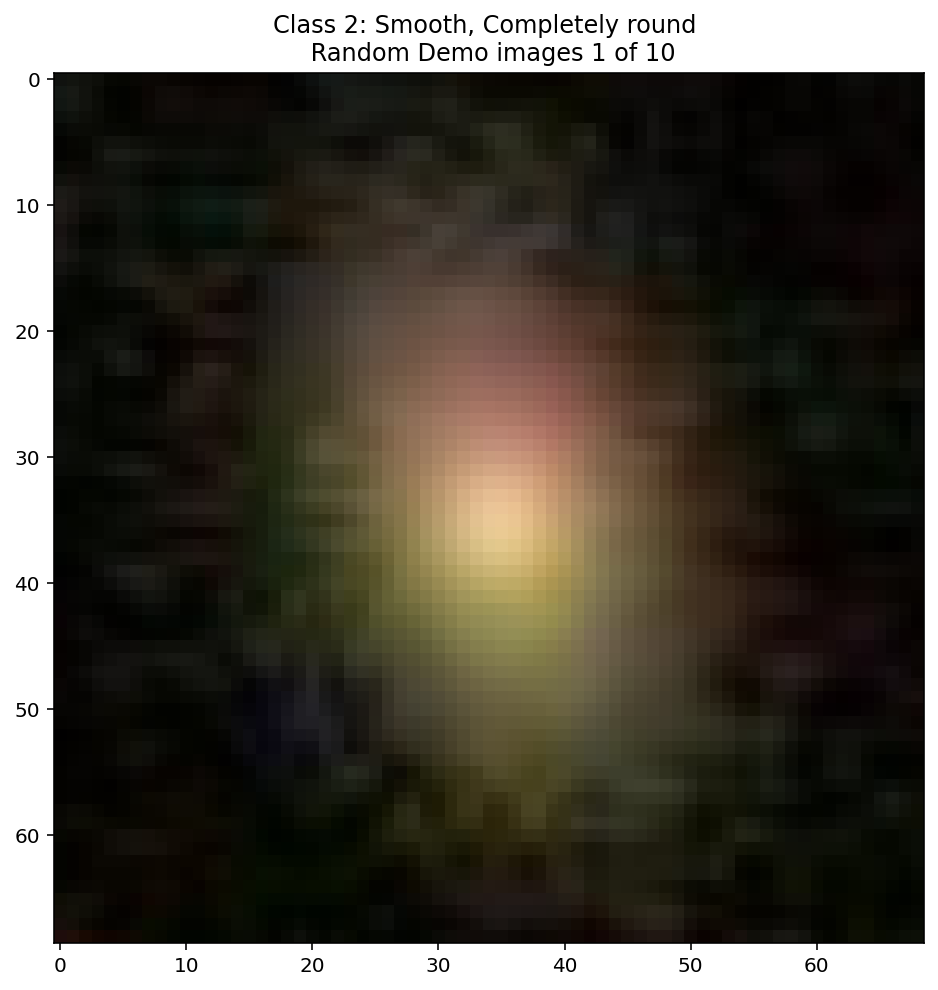

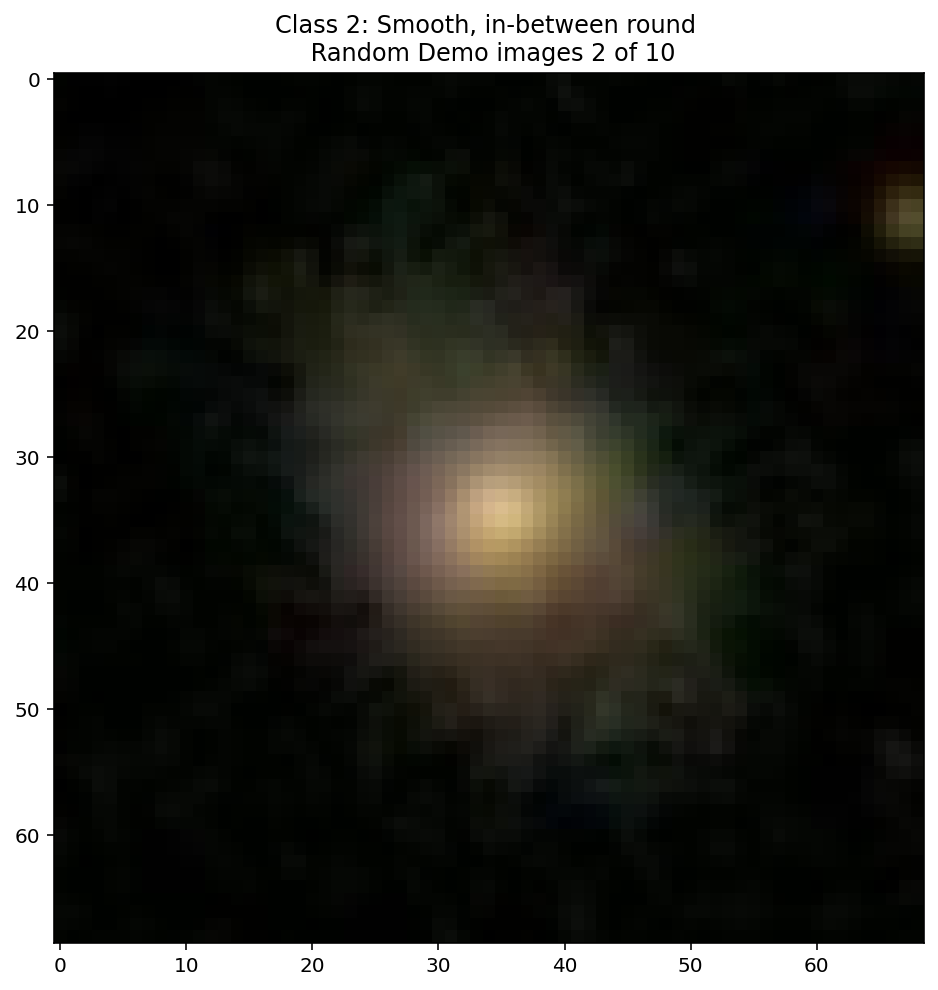

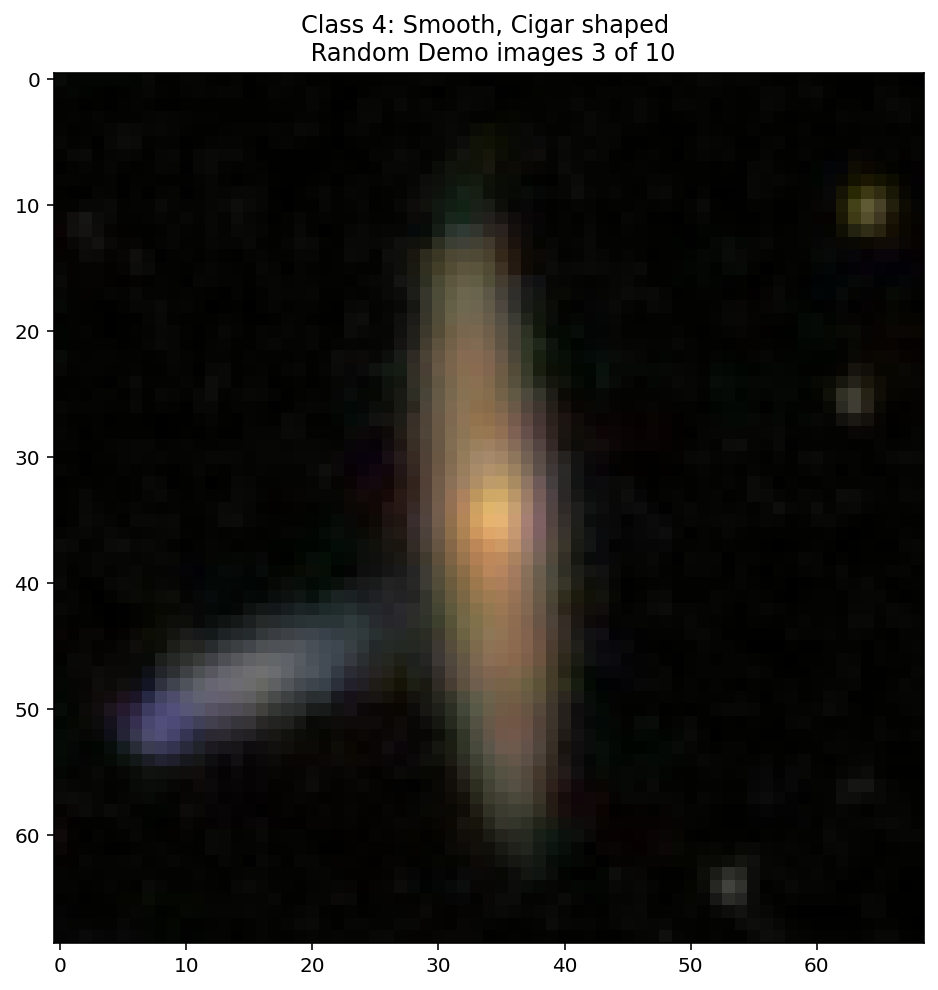

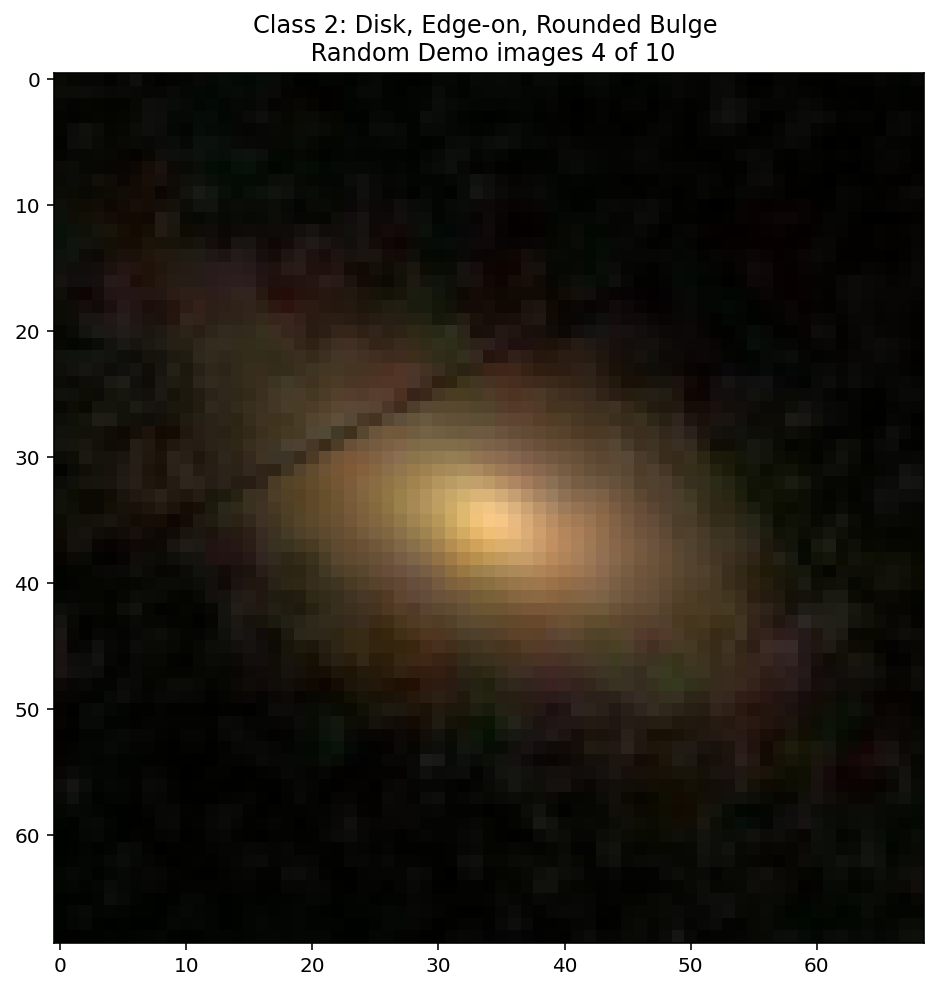

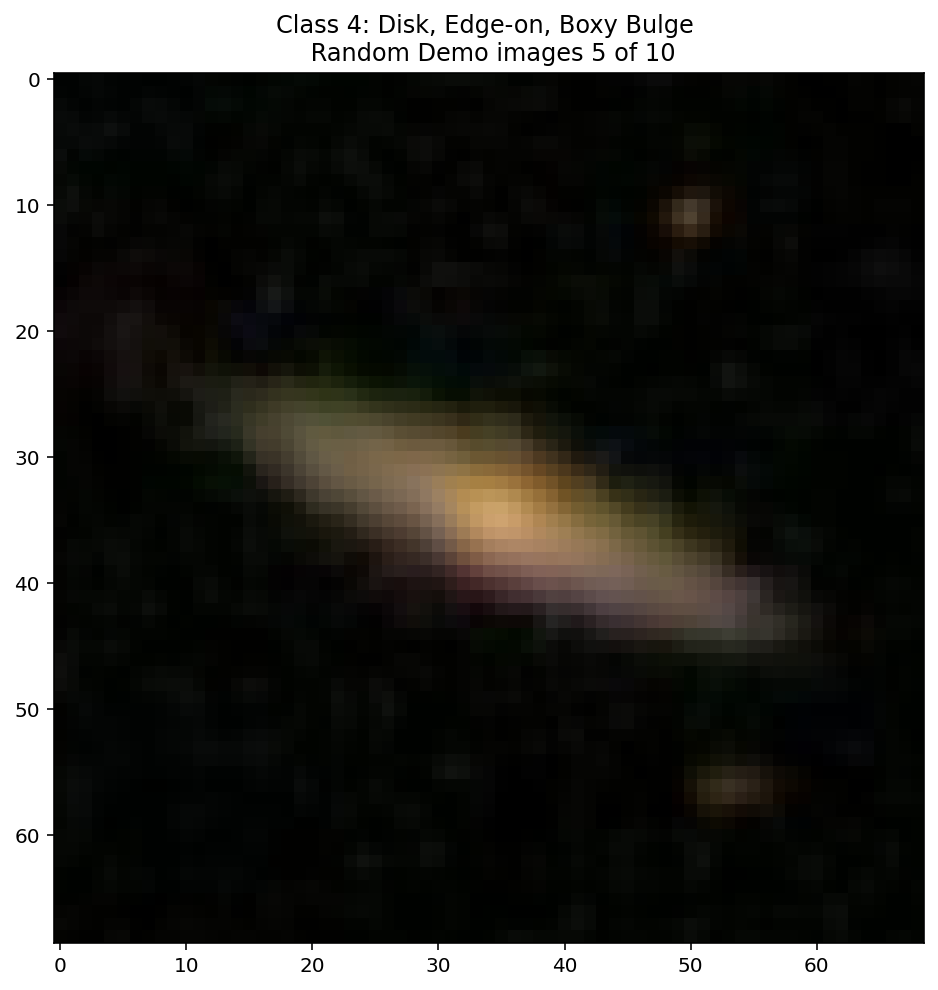

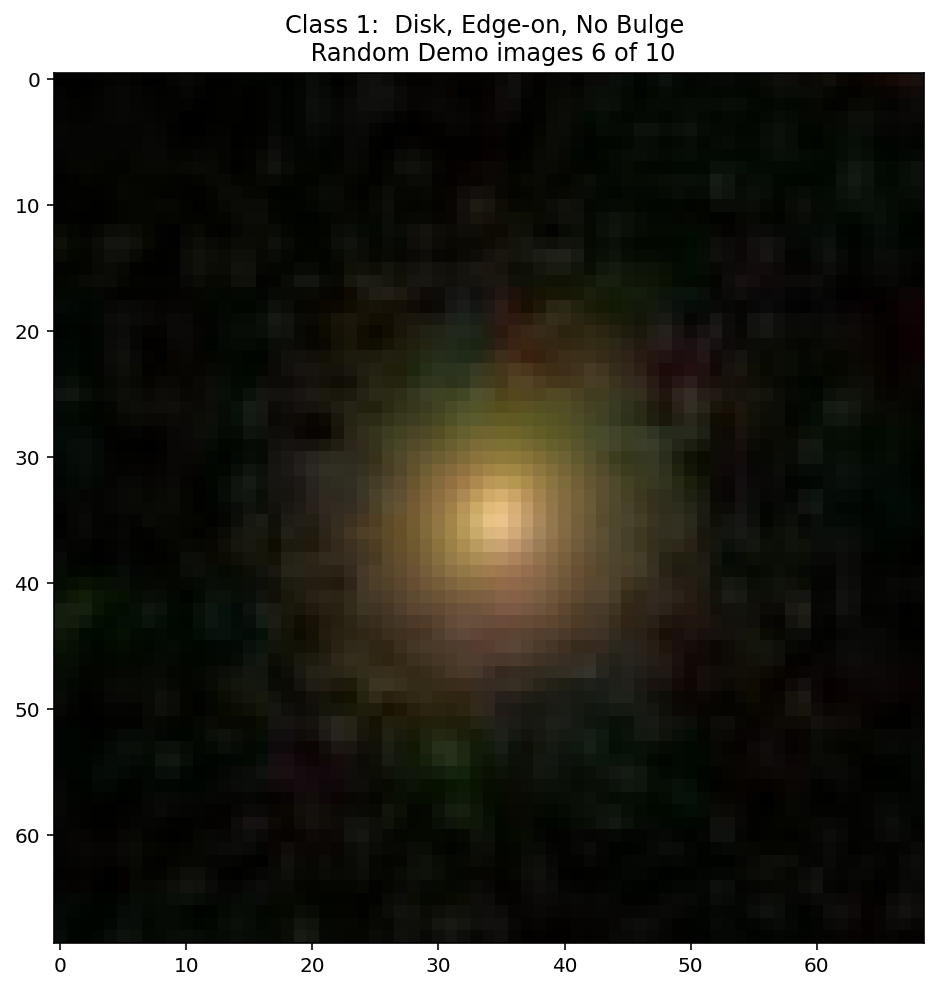

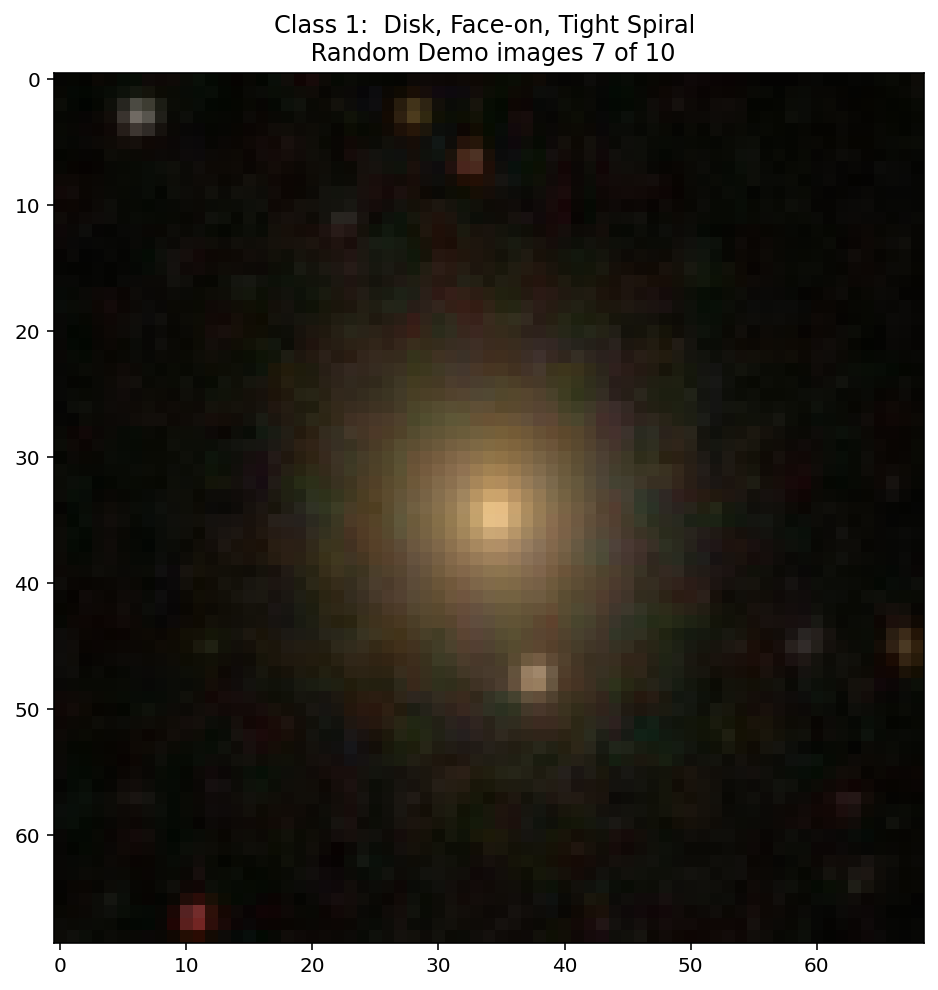

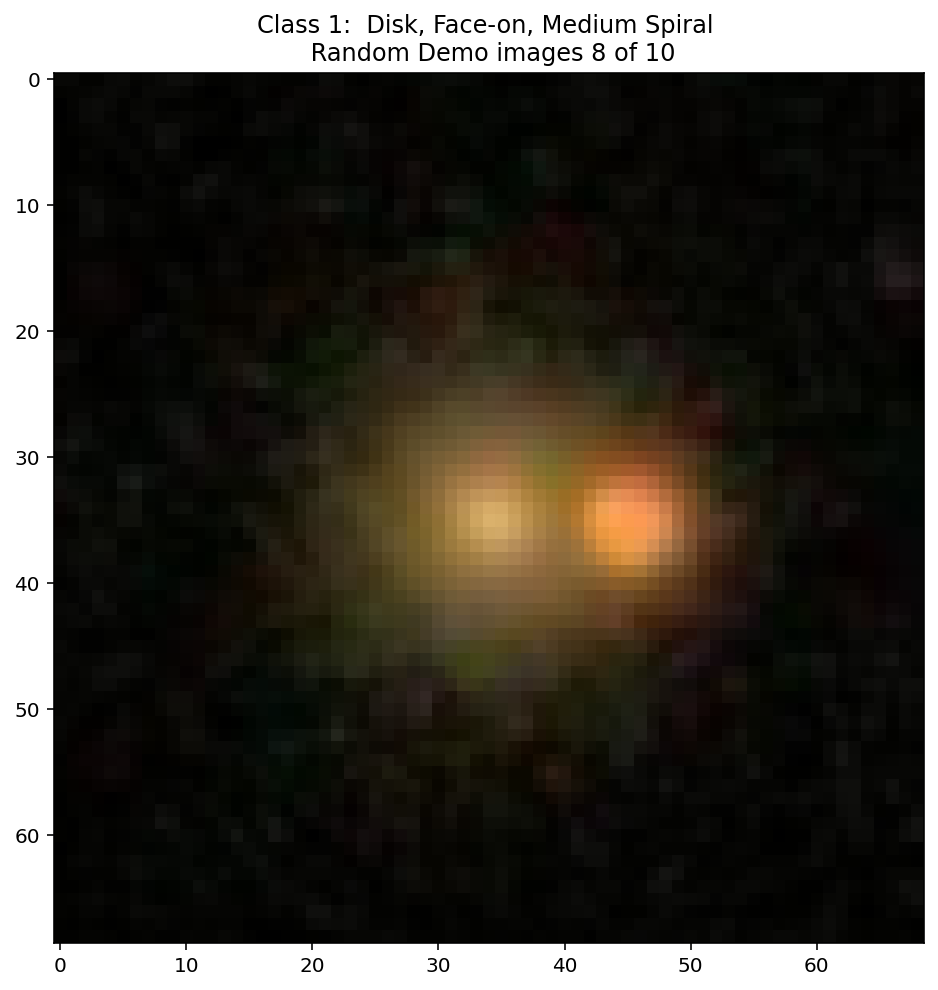

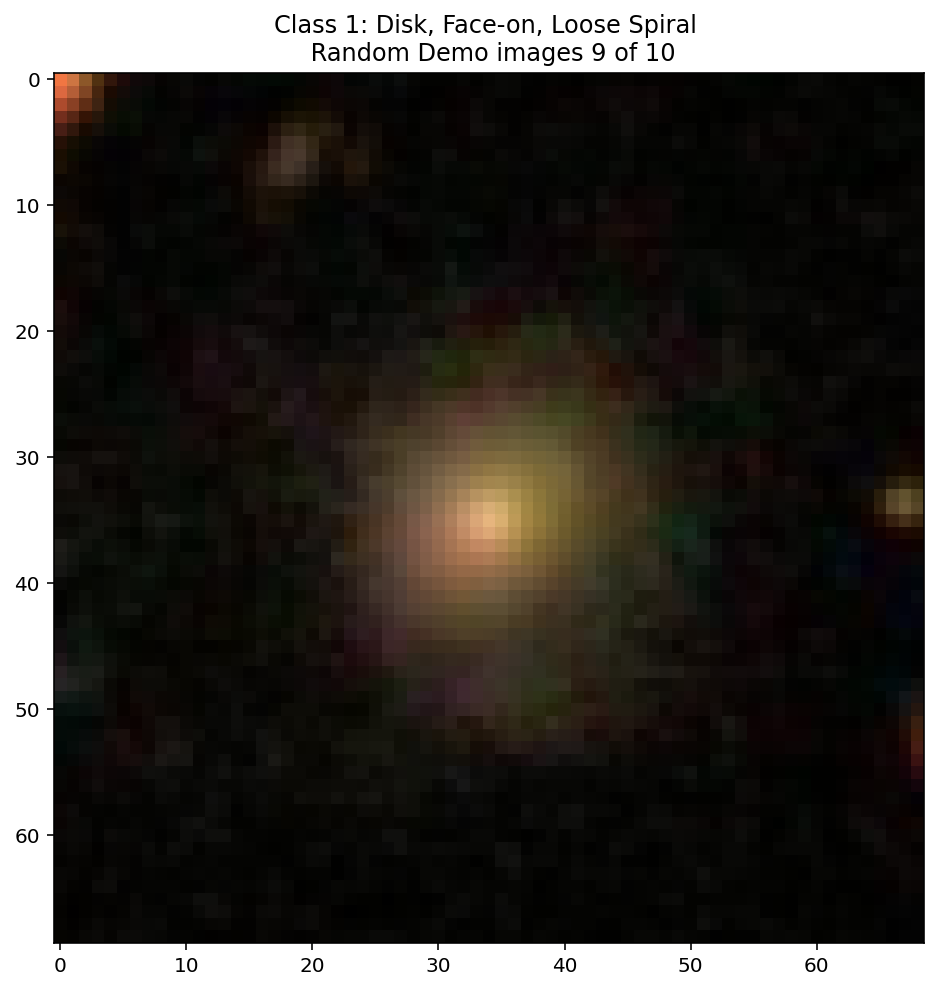

IndexError: list index out of range

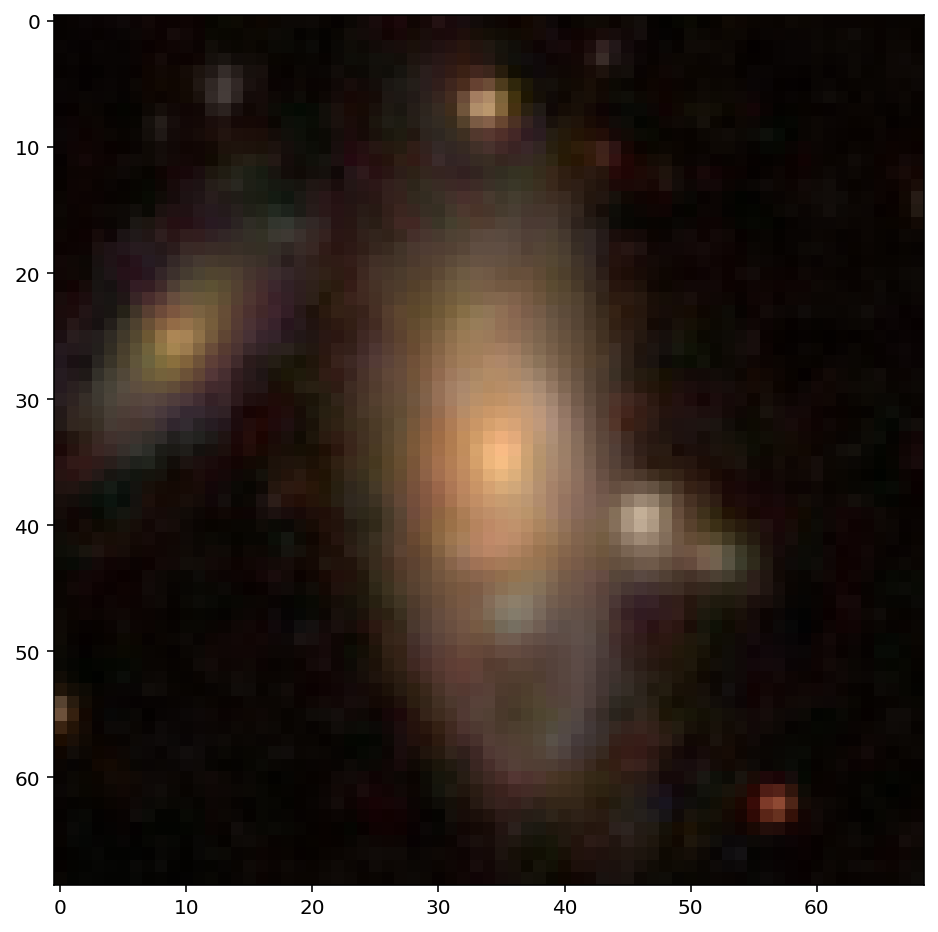

In [4]:
img = None
plt.ion()
print('===================Data Inspection===================')
for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=10).shape[0])):
    plt.figure(figsize=[8,8])
    img = plt.imshow(images[i]/255)
    
    plt.title('Class {}: {} \n Random Demo images {} of 10'.format(np.argmax(labels[i]), labelname[i],counter+1),fontsize=12)
    plt.draw()
    plt.pause(2.)
plt.close('all')
print('===============Data Inspection Finished===============')

In [24]:
import tensorflow as tf

#图像标准化
img = tf.image.per_image_standardization(images) 
images_std=img.numpy()

In [118]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.15)
train_images, train_labels, test_images, test_labels = images_std[train_idx], labels[train_idx], images_std[test_idx], labels[test_idx]

In [149]:
np.save('./resnet_models/train_ind.npy',train_idx)
np.save('./resnet_models/test_ind.npy',test_idx)

Text(0.5, 0, 'Each class')

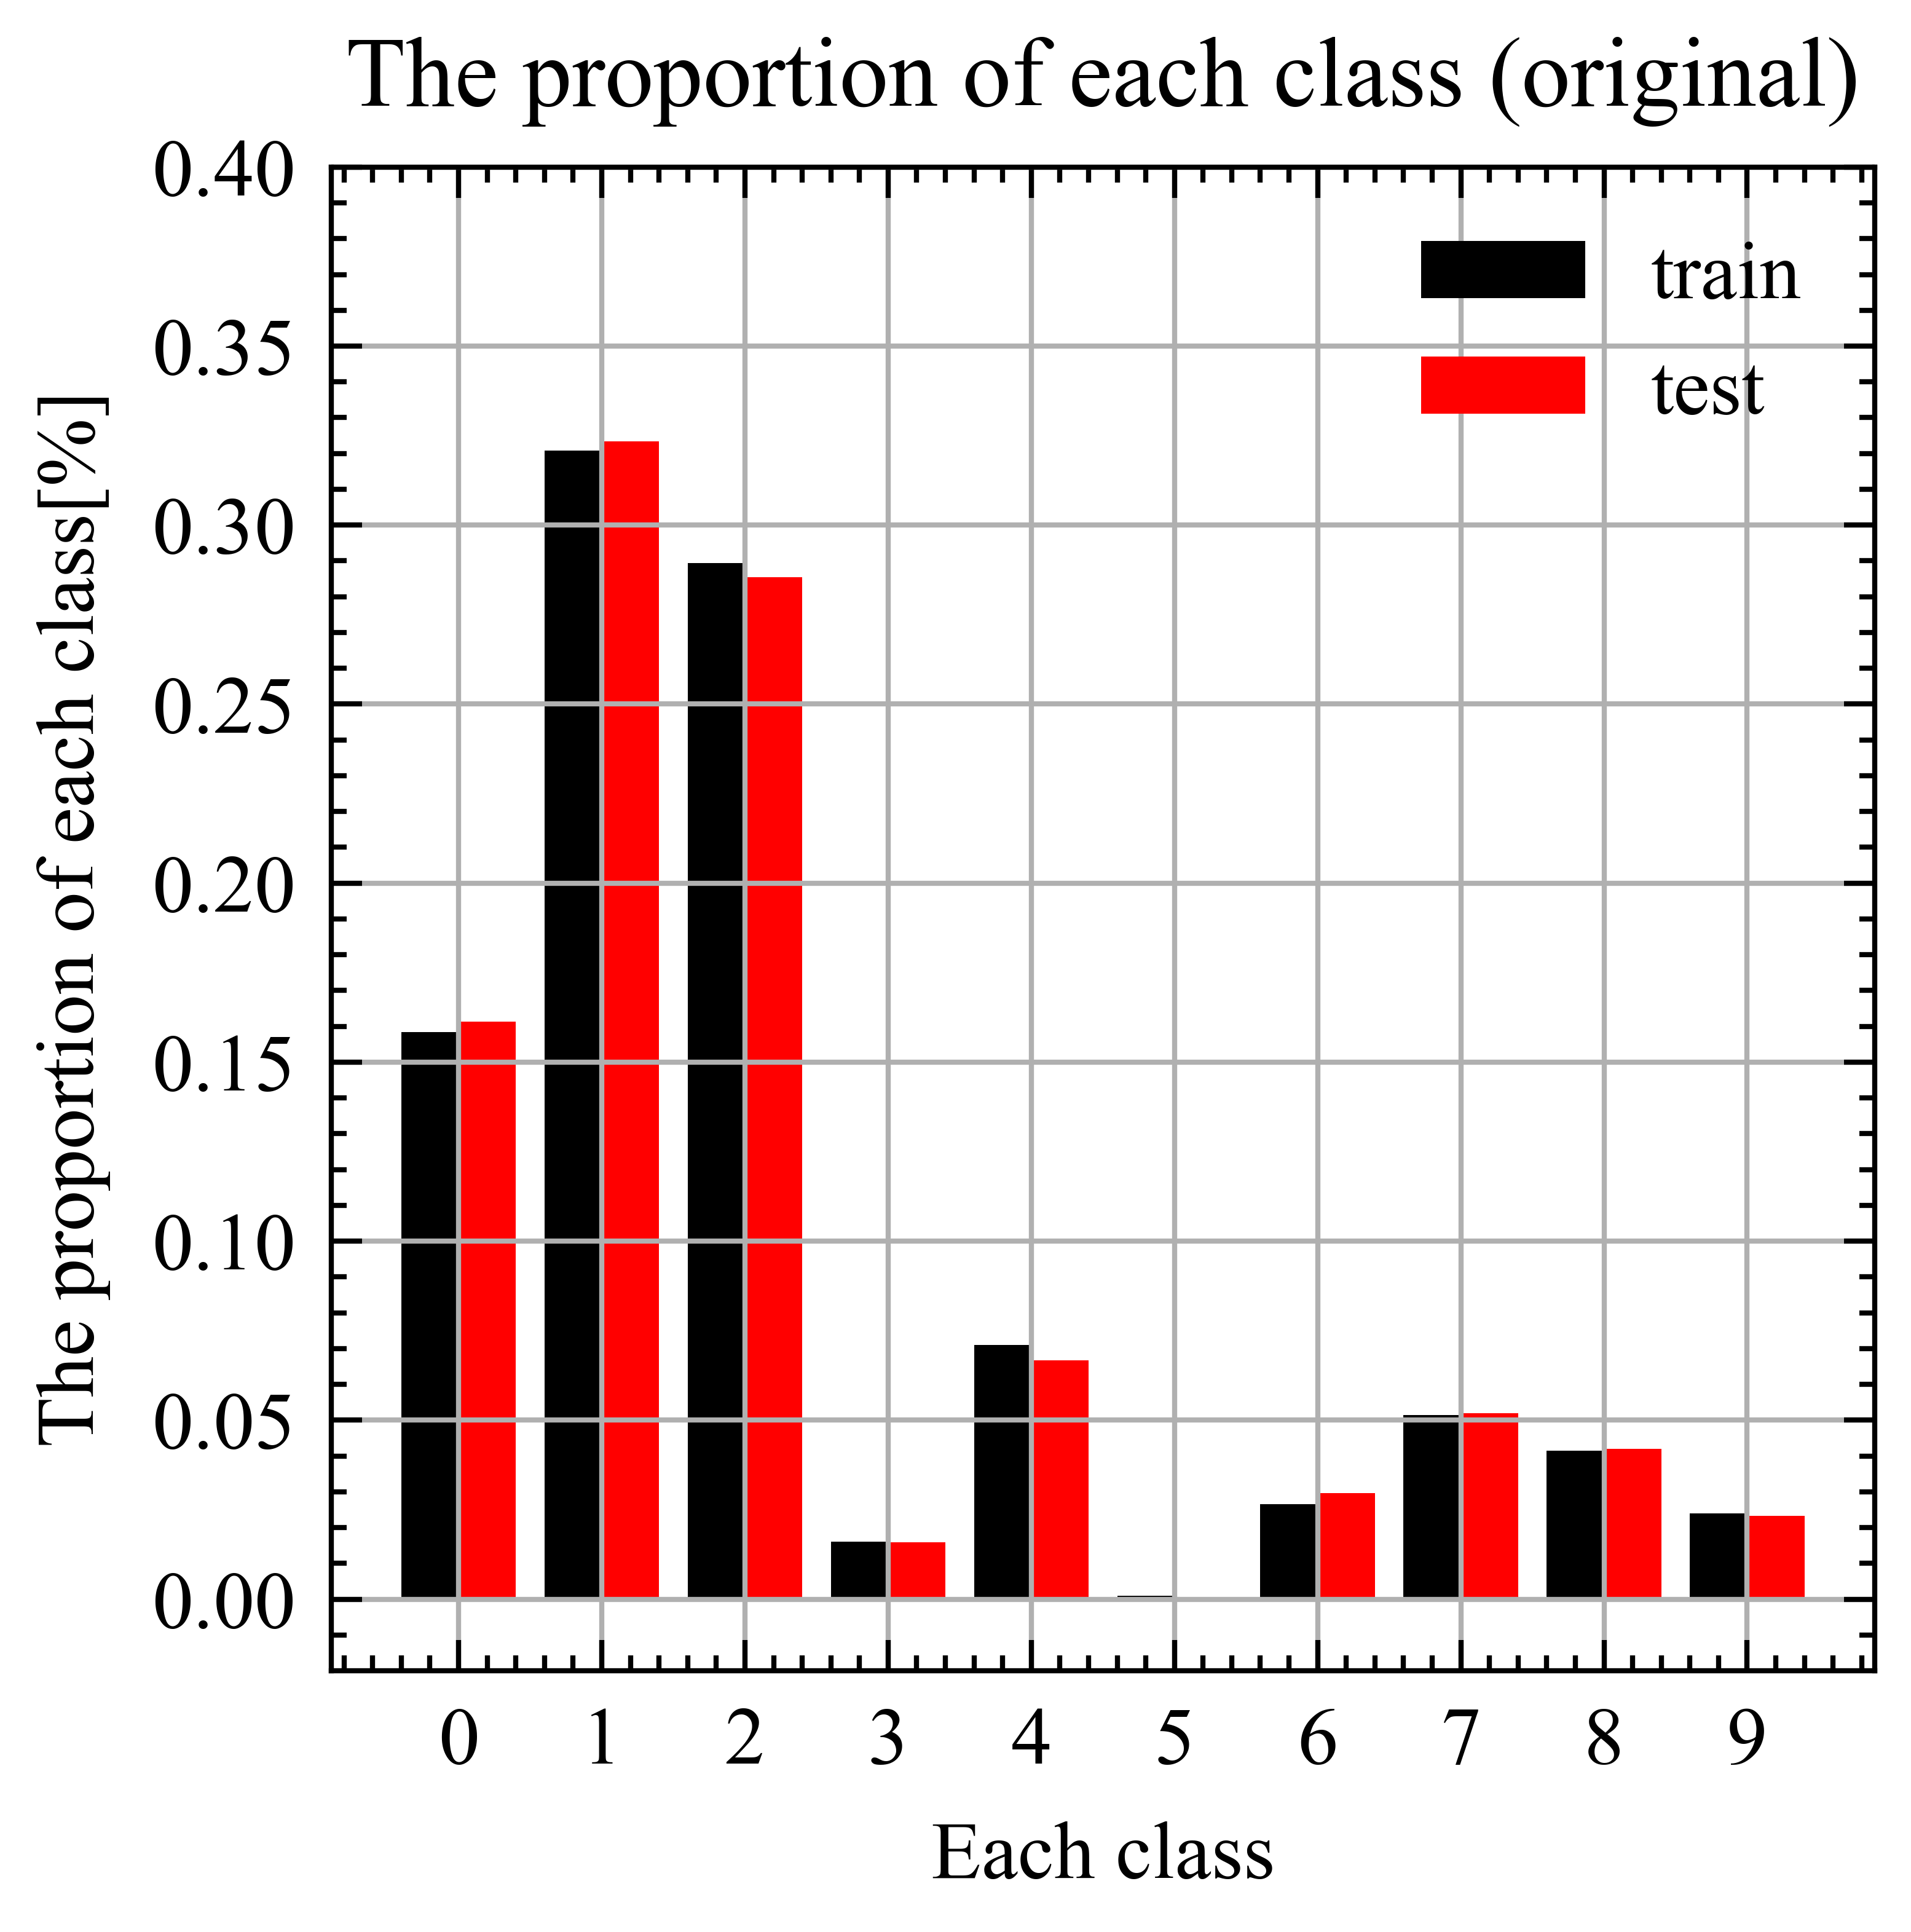

In [119]:
hist_train=np.zeros(10)
hist_test=np.zeros(10)
for i in range(train_labels.shape[0]):
    num=np.argmax(train_labels[i])
    hist_train[num]+=1
for i in range(test_labels.shape[0]):
    num=np.argmax(test_labels[i])
    hist_test[num]+=1


from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[2.7,2.7])
plt.bar(np.arange(10)-0.2,hist_train/train_labels.shape[0],width=0.4,label='train')

plt.bar(np.arange(10)+0.2,hist_test/test_labels.shape[0],width=0.4,label='test')
plt.grid('off')

x_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)

plt.ylim(-0.02,0.4)
plt.legend()
plt.title('The proportion of each class (original)')
plt.ylabel('The proportion of each class[%]')
plt.xlabel('Each class')

In [141]:
hist_test

array([5.270e+02, 1.057e+03, 9.330e+02, 5.200e+01, 2.180e+02, 1.000e+00,
       9.700e+01, 1.700e+02, 1.370e+02, 7.600e+01])

In [142]:
hist_train

array([2934., 5940., 5359.,  297., 1316.,   16.,  492.,  951.,  769.,
        443.])

In [128]:
#初步尝试，选择了默认规模
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
import numpy as np
import os

# 定义基本块
def basic_block(x, filters, stride=1):
    shortcut = x
    print("Input shape:", x.shape)

    # 第一个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 第二个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果步幅不为 1，或输入和输出通道数不匹配，则需要对 shortcut 进行调整
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # 添加 shortcut 到主路径上
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    print("Output shape:", x.shape)

    return x

# 定义 ResNet 结构
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # 堆叠残差块
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)

    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128, stride=1)
    x = basic_block(x, filters=128, stride=1)
    x = basic_block(x, filters=128, stride=1)

    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)

    x = basic_block(x, filters=512, stride=2)
    x = basic_block(x, filters=512, stride=1)
    x = basic_block(x, filters=512, stride=1)

    # 全局平均池化
    x = GlobalAveragePooling2D()(x)

    # 全连接层
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def prepare_data(train_images, train_labels, test_images, test_labels):
    
    trlabels=np.zeros(train_labels.shape[0])
    telabels=np.zeros(test_labels.shape[0])
   
    for i in range(train_labels.shape[0]):
        trlabels[i]=np.argmax(train_labels[i])
    for i in range(test_labels.shape[0]):
        telabels[i]=np.argmax(test_labels[i])
    
    return trlabels,  telabels

# 模型训练
def train_model():
    input_shape = (69, 69, 3)
    num_classes = 10

    model = ResNet(input_shape, num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
    
    # 训练模型并保存每个epoch的模型
    for epoch in range(10):  # 假设训练10个epoch
        model.fit(train_images, trlabels, batch_size=64, epochs=1, validation_data=(test_images, telabels))
        model.save(f'resnet_models/resnet_epoch_{epoch+1}.h5')

    #model.fit(train_images, trlabels, epochs=10, batch_size=32, validation_data=(test_images, telabels))

    return model



# 有没有模型
if not os.path.exists('resnet_models'):
    os.makedirs('resnet_models')



trained_model = train_model()



Input shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Output shape: (None, 3, 3, 512)
Input shape: (None, 3, 3, 512)
Output shape: (None, 3, 3, 512)
Input shape: (None, 3, 3, 512)
Output shape: (No

In [132]:
# 模型测试
def test_model(model):
    
    loss, accuracy = model.evaluate(test_images, telabels)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    
#输出结果
def predict_image(test_images, telabels, model):
    
    predictions = model.predict(test_images)
    predicted_label=np.zeros(predictions.shape[0])
    for i in range(predictions.shape[0]):
        predicted_label[i] = np.argmax(predictions[i])
    return predicted_label


loaded_model = tf.keras.models.load_model('resnet_models/resnet_epoch_8.h5')
trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
pre_labels=predict_image(test_images, telabels, loaded_model)


103/103 [==============================] - 6s 47ms/step


In [133]:
confusion_matrix = np.zeros((10,10))

# create the confusion matrix
for i in range(telabels.shape[0]):
    confusion_matrix[int(pre_labels[i]),int(telabels[i]) ] += 1


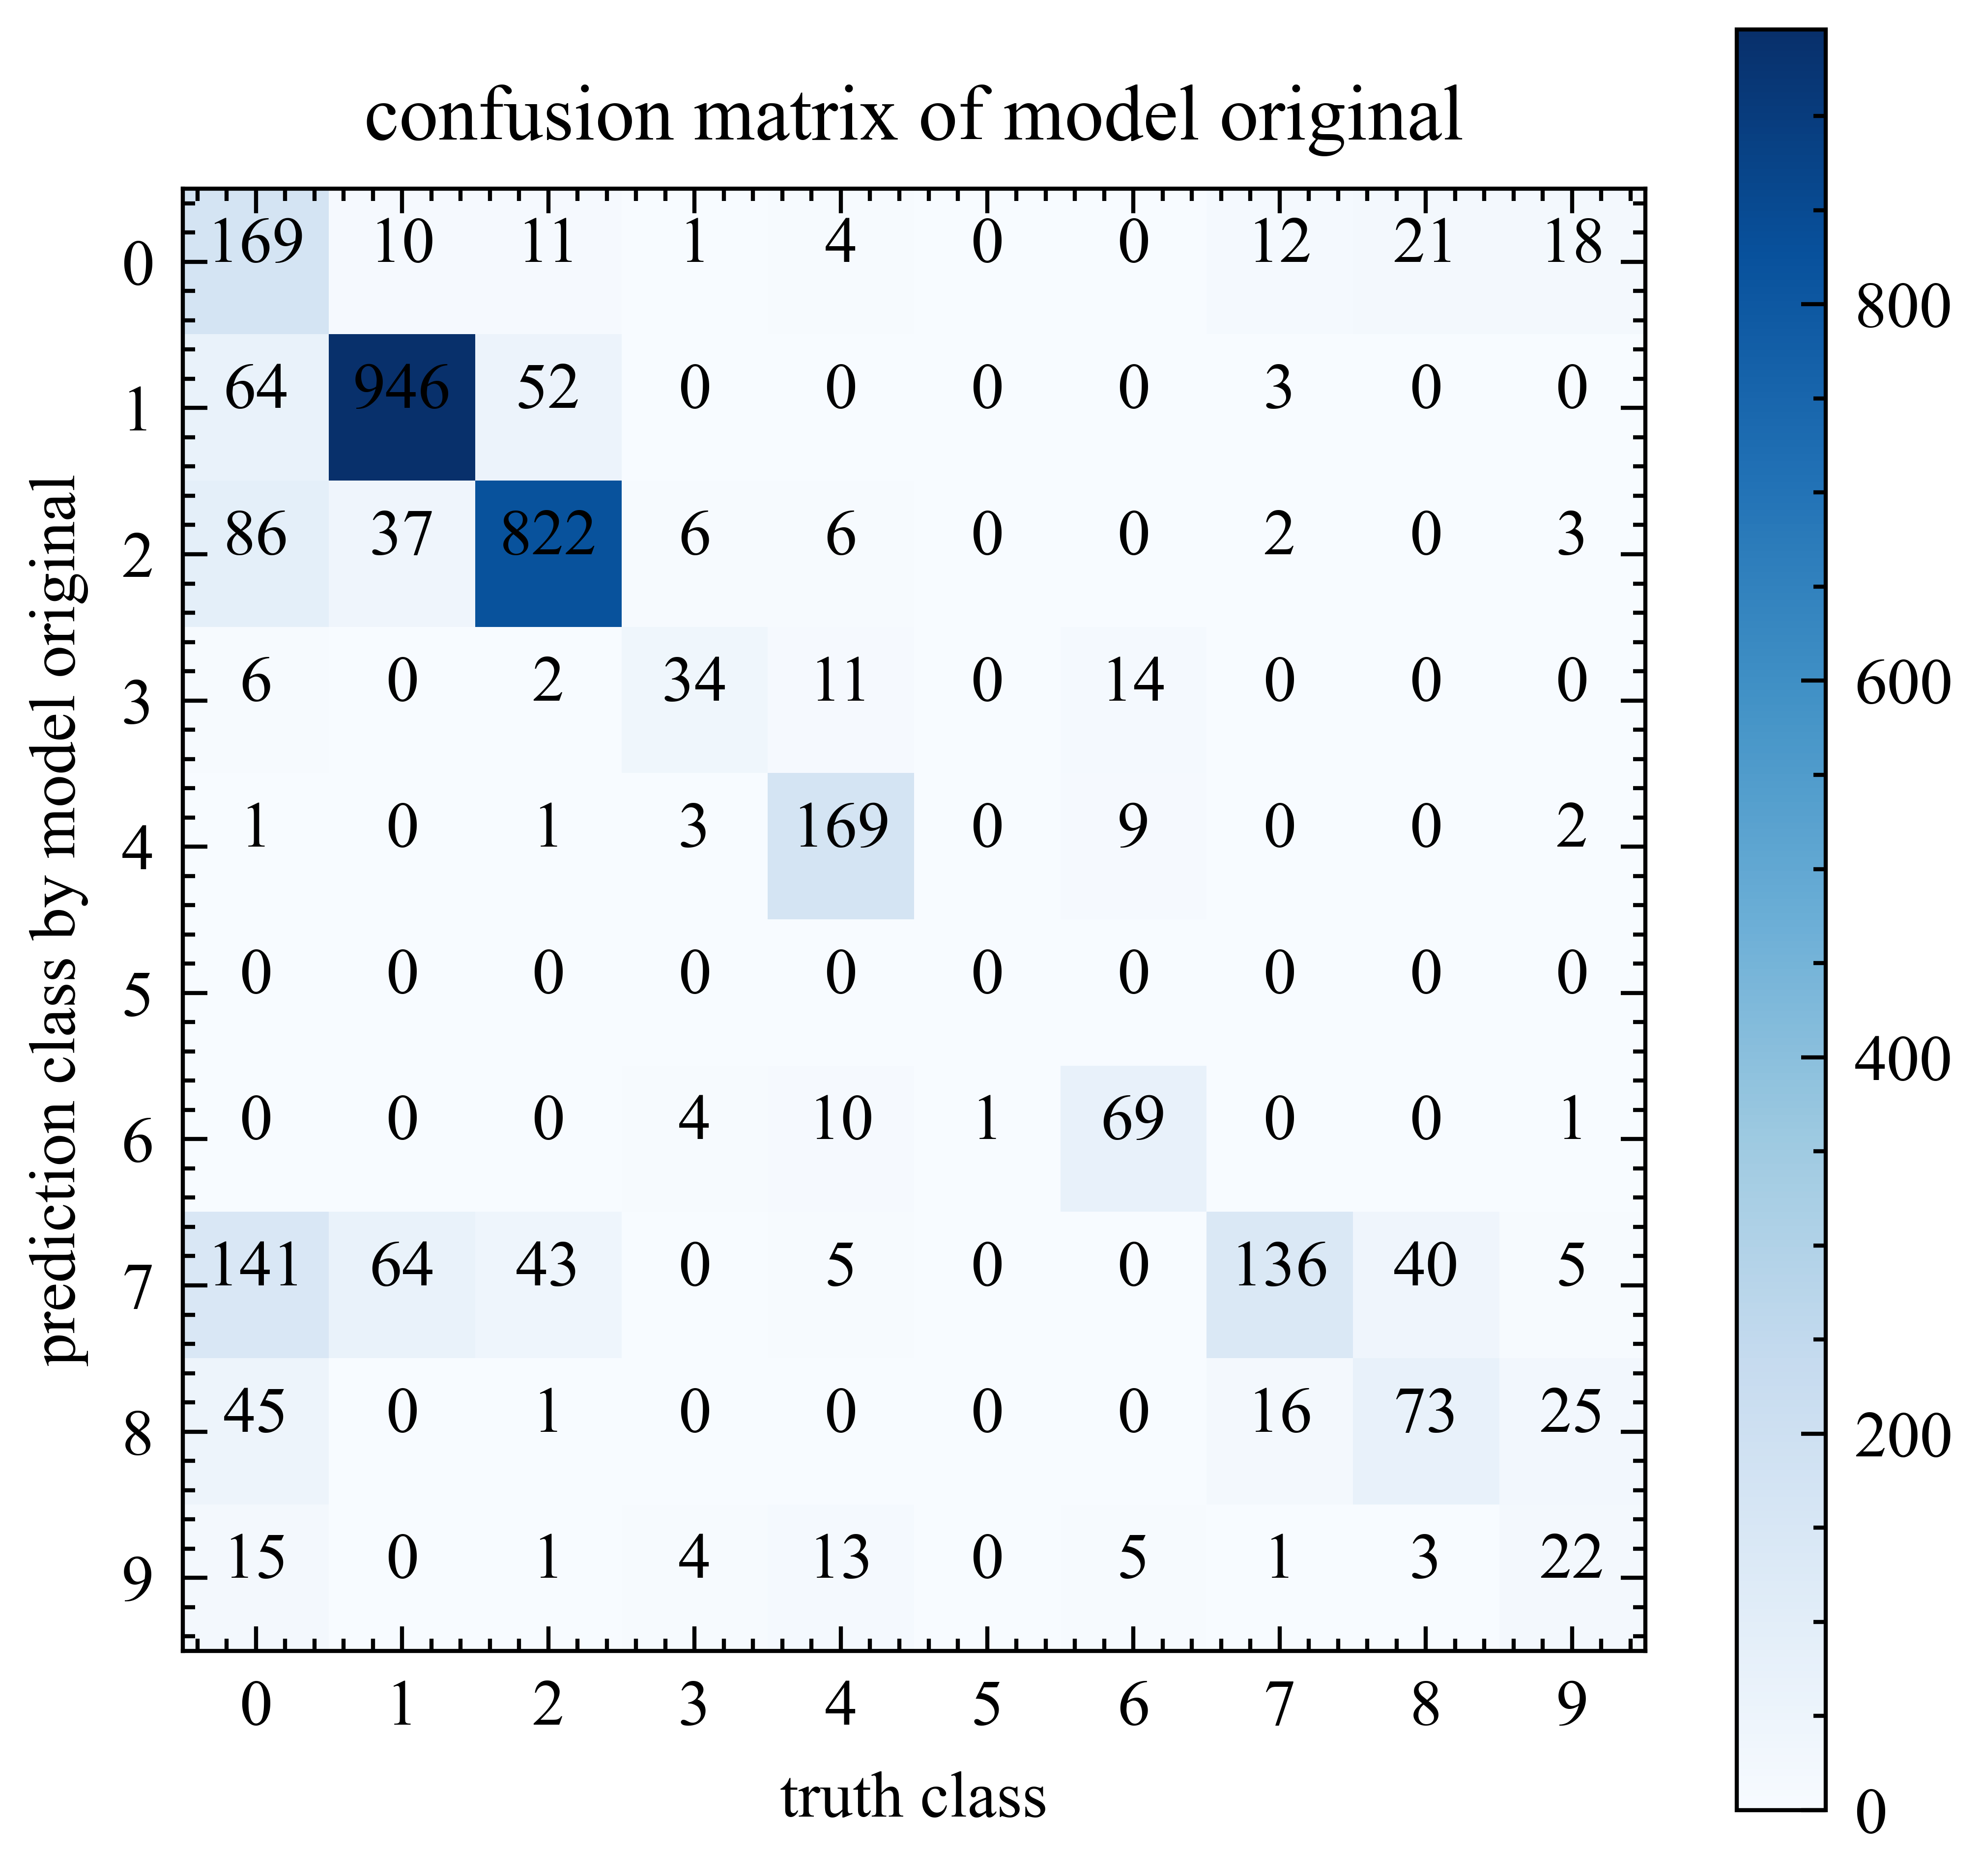

In [134]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], '.0f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix[i, j] > 0.5 else "black")
plt.title('confusion matrix of model original')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)



In [143]:
confusion_matrix_per = confusion_matrix.copy()

# create the confusion matrix
for i in range(10):
    confusion_matrix_per[i,:] /=np.sum(confusion_matrix,0)


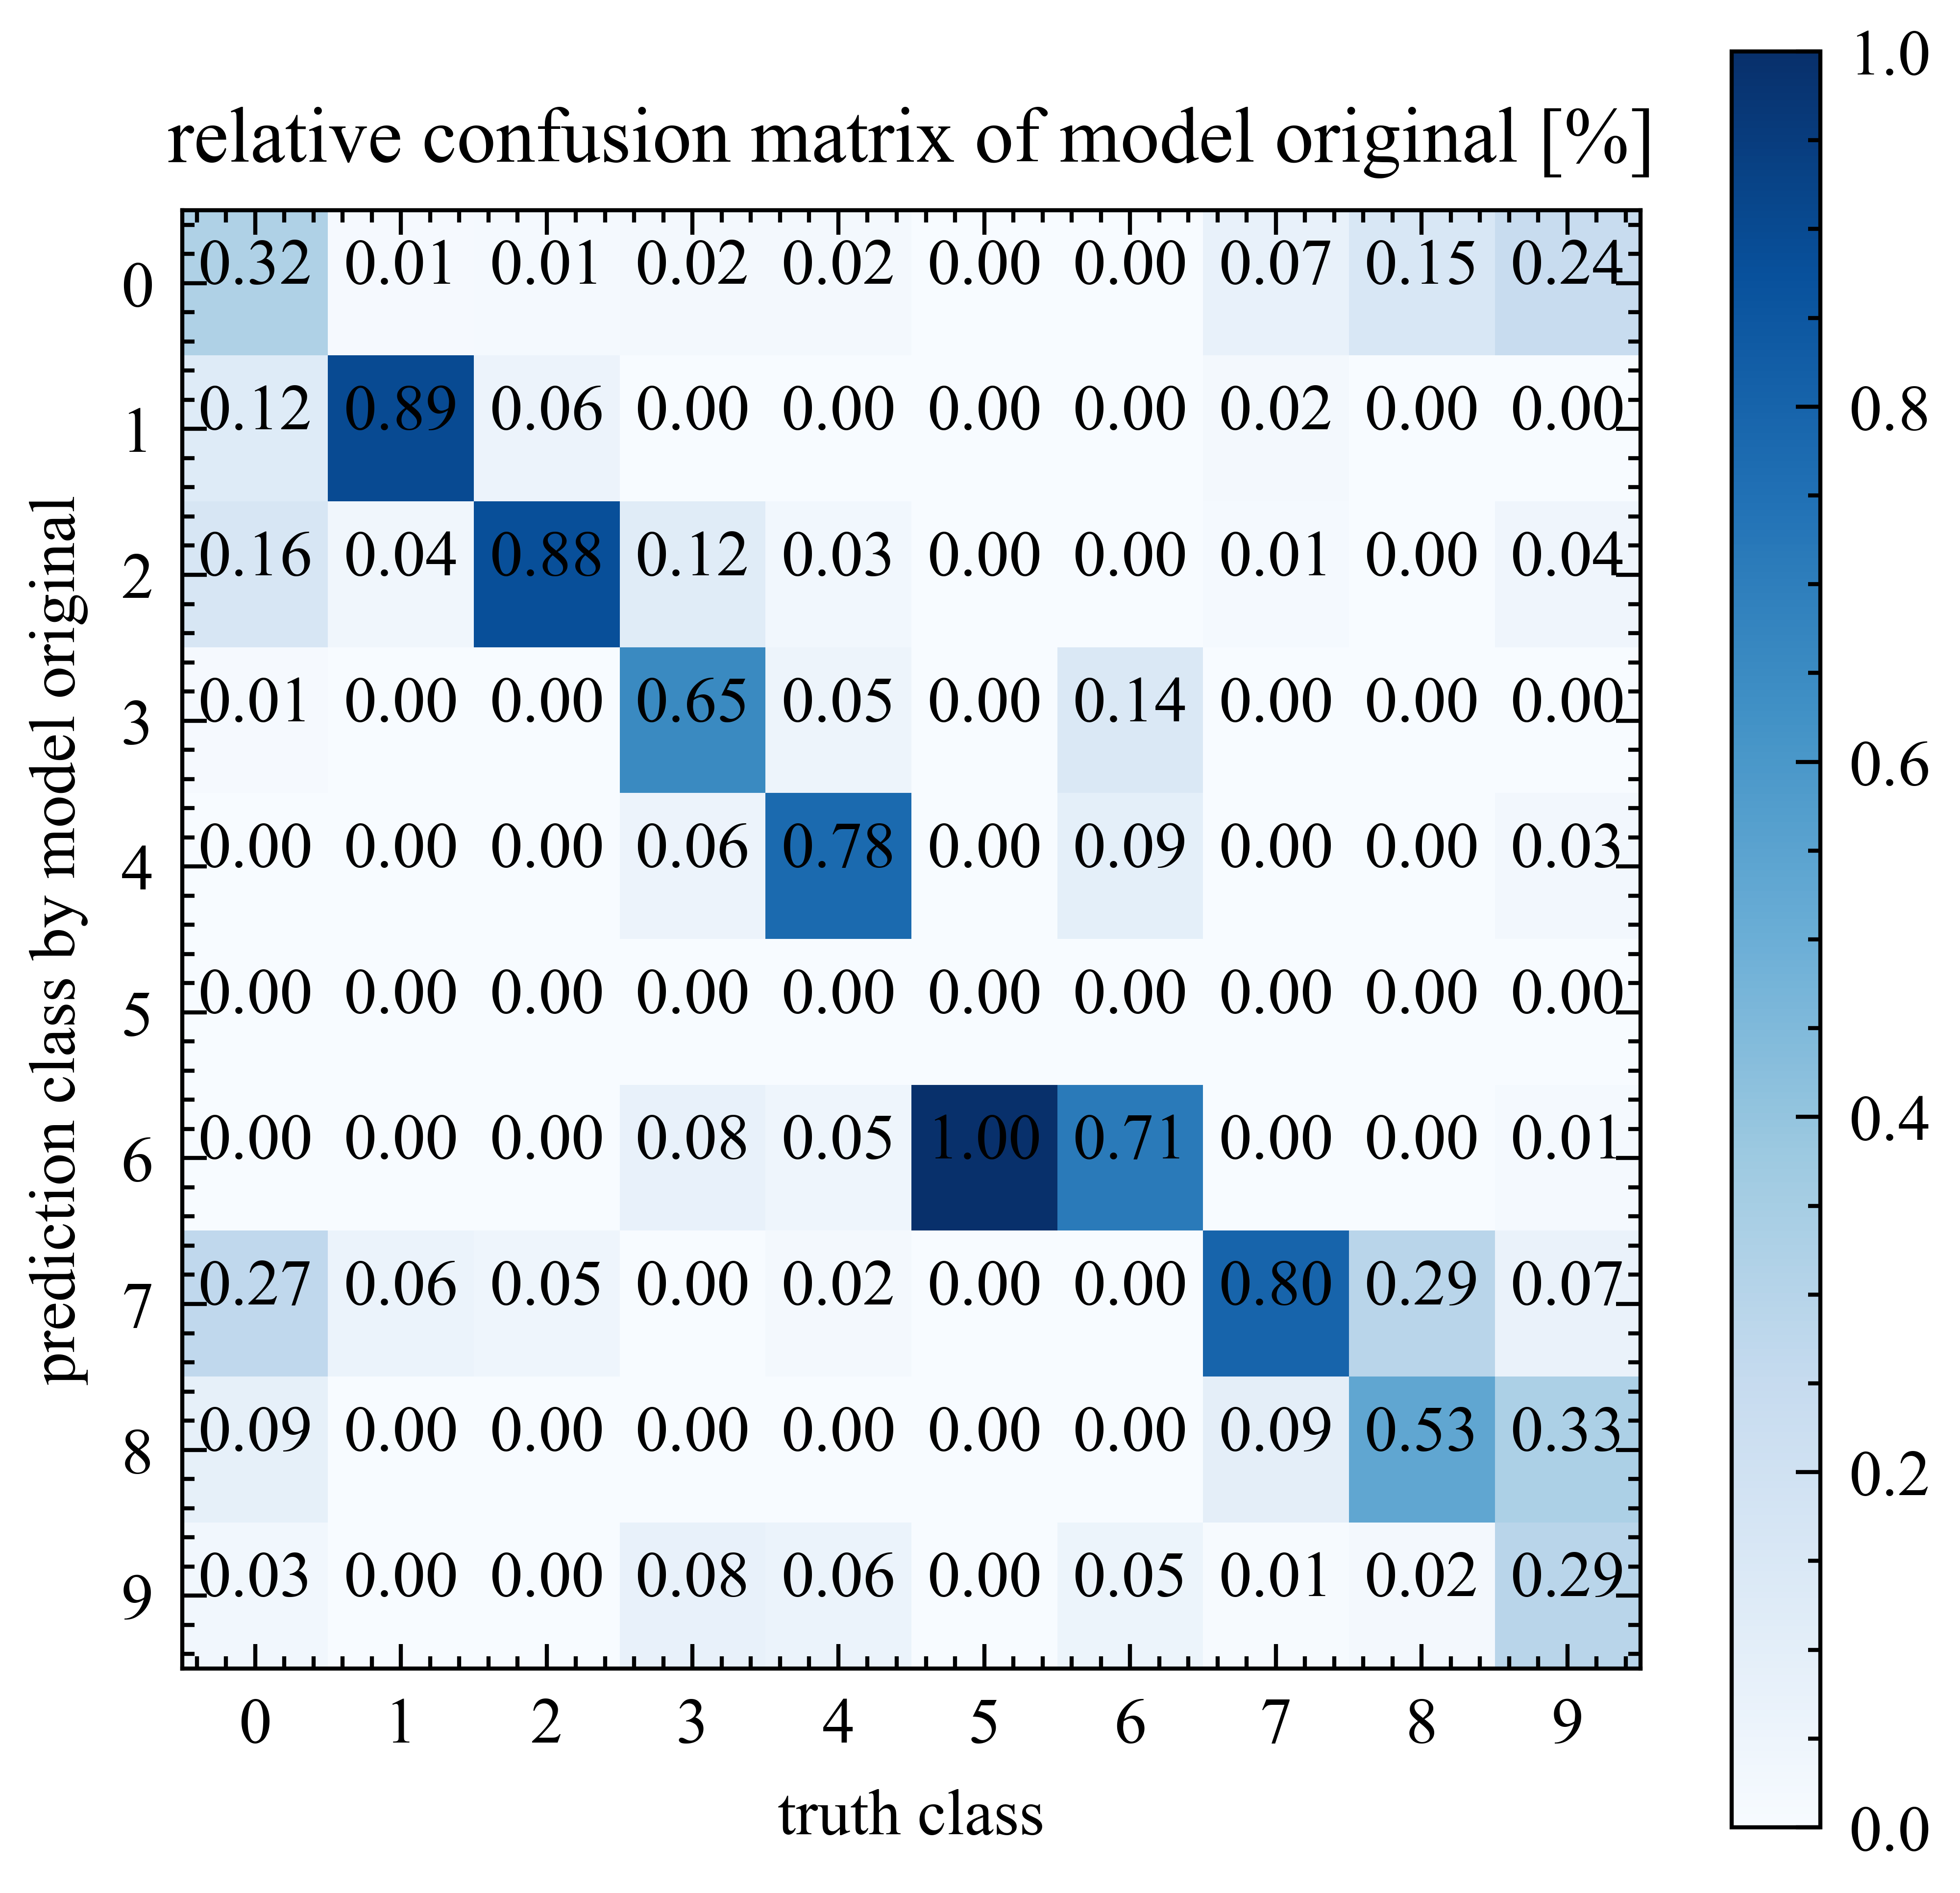

In [144]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix_per,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix_per[i, j], '.2f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix_per[i, j] > 0.5 else "black")
plt.title('relative confusion matrix of model original [%]')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

In [159]:
#增大网络规模
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

# 定义基本块
def basic_block(x, filters, stride=1):
    print("Input shape:", x.shape)
    shortcut = x

    # 第一个卷积层
    x = Conv2D(filters, kernel_size=(5, 5), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 第二个卷积层
    x = Conv2D(filters, kernel_size=(5, 5), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果步幅不为 1，或输入和输出通道数不匹配，则需要对 shortcut 进行调整
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    print("Skip connection shape:", x.shape)

    # 添加 shortcut 到主路径上
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    print("Output shape:", x.shape)

    return x

# 定义 ResNet 结构
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # 堆叠残差块
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)

    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128, stride=1)
    x = basic_block(x, filters=128, stride=1)
    #x = basic_block(x, filters=128, stride=1)

    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)

    x = basic_block(x, filters=512, stride=2)
    x = basic_block(x, filters=512, stride=1)
    #x = basic_block(x, filters=512, stride=1)

    # 全局平均池化
    x = GlobalAveragePooling2D()(x)

    # 全连接层 增加了两层
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def prepare_data(train_images, train_labels, test_images, test_labels):
    
    trlabels=np.zeros(train_labels.shape[0])
    telabels=np.zeros(test_labels.shape[0])
   
    for i in range(train_labels.shape[0]):
        trlabels[i]=np.argmax(train_labels[i])
    for i in range(test_labels.shape[0]):
        telabels[i]=np.argmax(test_labels[i])
    
    return trlabels,  telabels

# 模型训练
def train_model():
    input_shape = (69, 69, 3)
    num_classes = 10

    
    model = ResNet(input_shape, num_classes)
    optimizer = Adam(learning_rate=0.001)

# 将优化器对象传入compile函数中
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
    
    # 训练模型并保存每个epoch的模型
    for epoch in range(20):  # 假设训练10个epoch
        model.fit(train_images, trlabels, batch_size=64, epochs=1, validation_data=(test_images, telabels))
        model.save(f'resnet_models_dense/resnet_epoch_{epoch+1}.h5')

    #model.fit(train_images, trlabels, epochs=10, batch_size=32, validation_data=(test_images, telabels))

    return model



# 有没有模型
if not os.path.exists('resnet_models_dense'):
    os.makedirs('resnet_models_dense')



trained_model = train_model()



Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: 

In [162]:
# 模型测试
def test_model(model):
    
    loss, accuracy = model.evaluate(test_images, telabels)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    
#输出结果
def predict_image(test_images, telabels, model):
    
    predictions = model.predict(test_images)
    predicted_label=np.zeros(predictions.shape[0])
    for i in range(predictions.shape[0]):
        predicted_label[i] = np.argmax(predictions[i])
    return predicted_label


loaded_model = tf.keras.models.load_model('./resnet_models_dense/resnet_epoch_17.h5')
trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
pre_labels=predict_image(test_images, telabels, loaded_model)


103/103 [==============================] - 6s 50ms/step


In [163]:
confusion_matrix = np.zeros((10,10))

# create the confusion matrix
for i in range(telabels.shape[0]):
    confusion_matrix[int(pre_labels[i]),int(telabels[i]) ] += 1


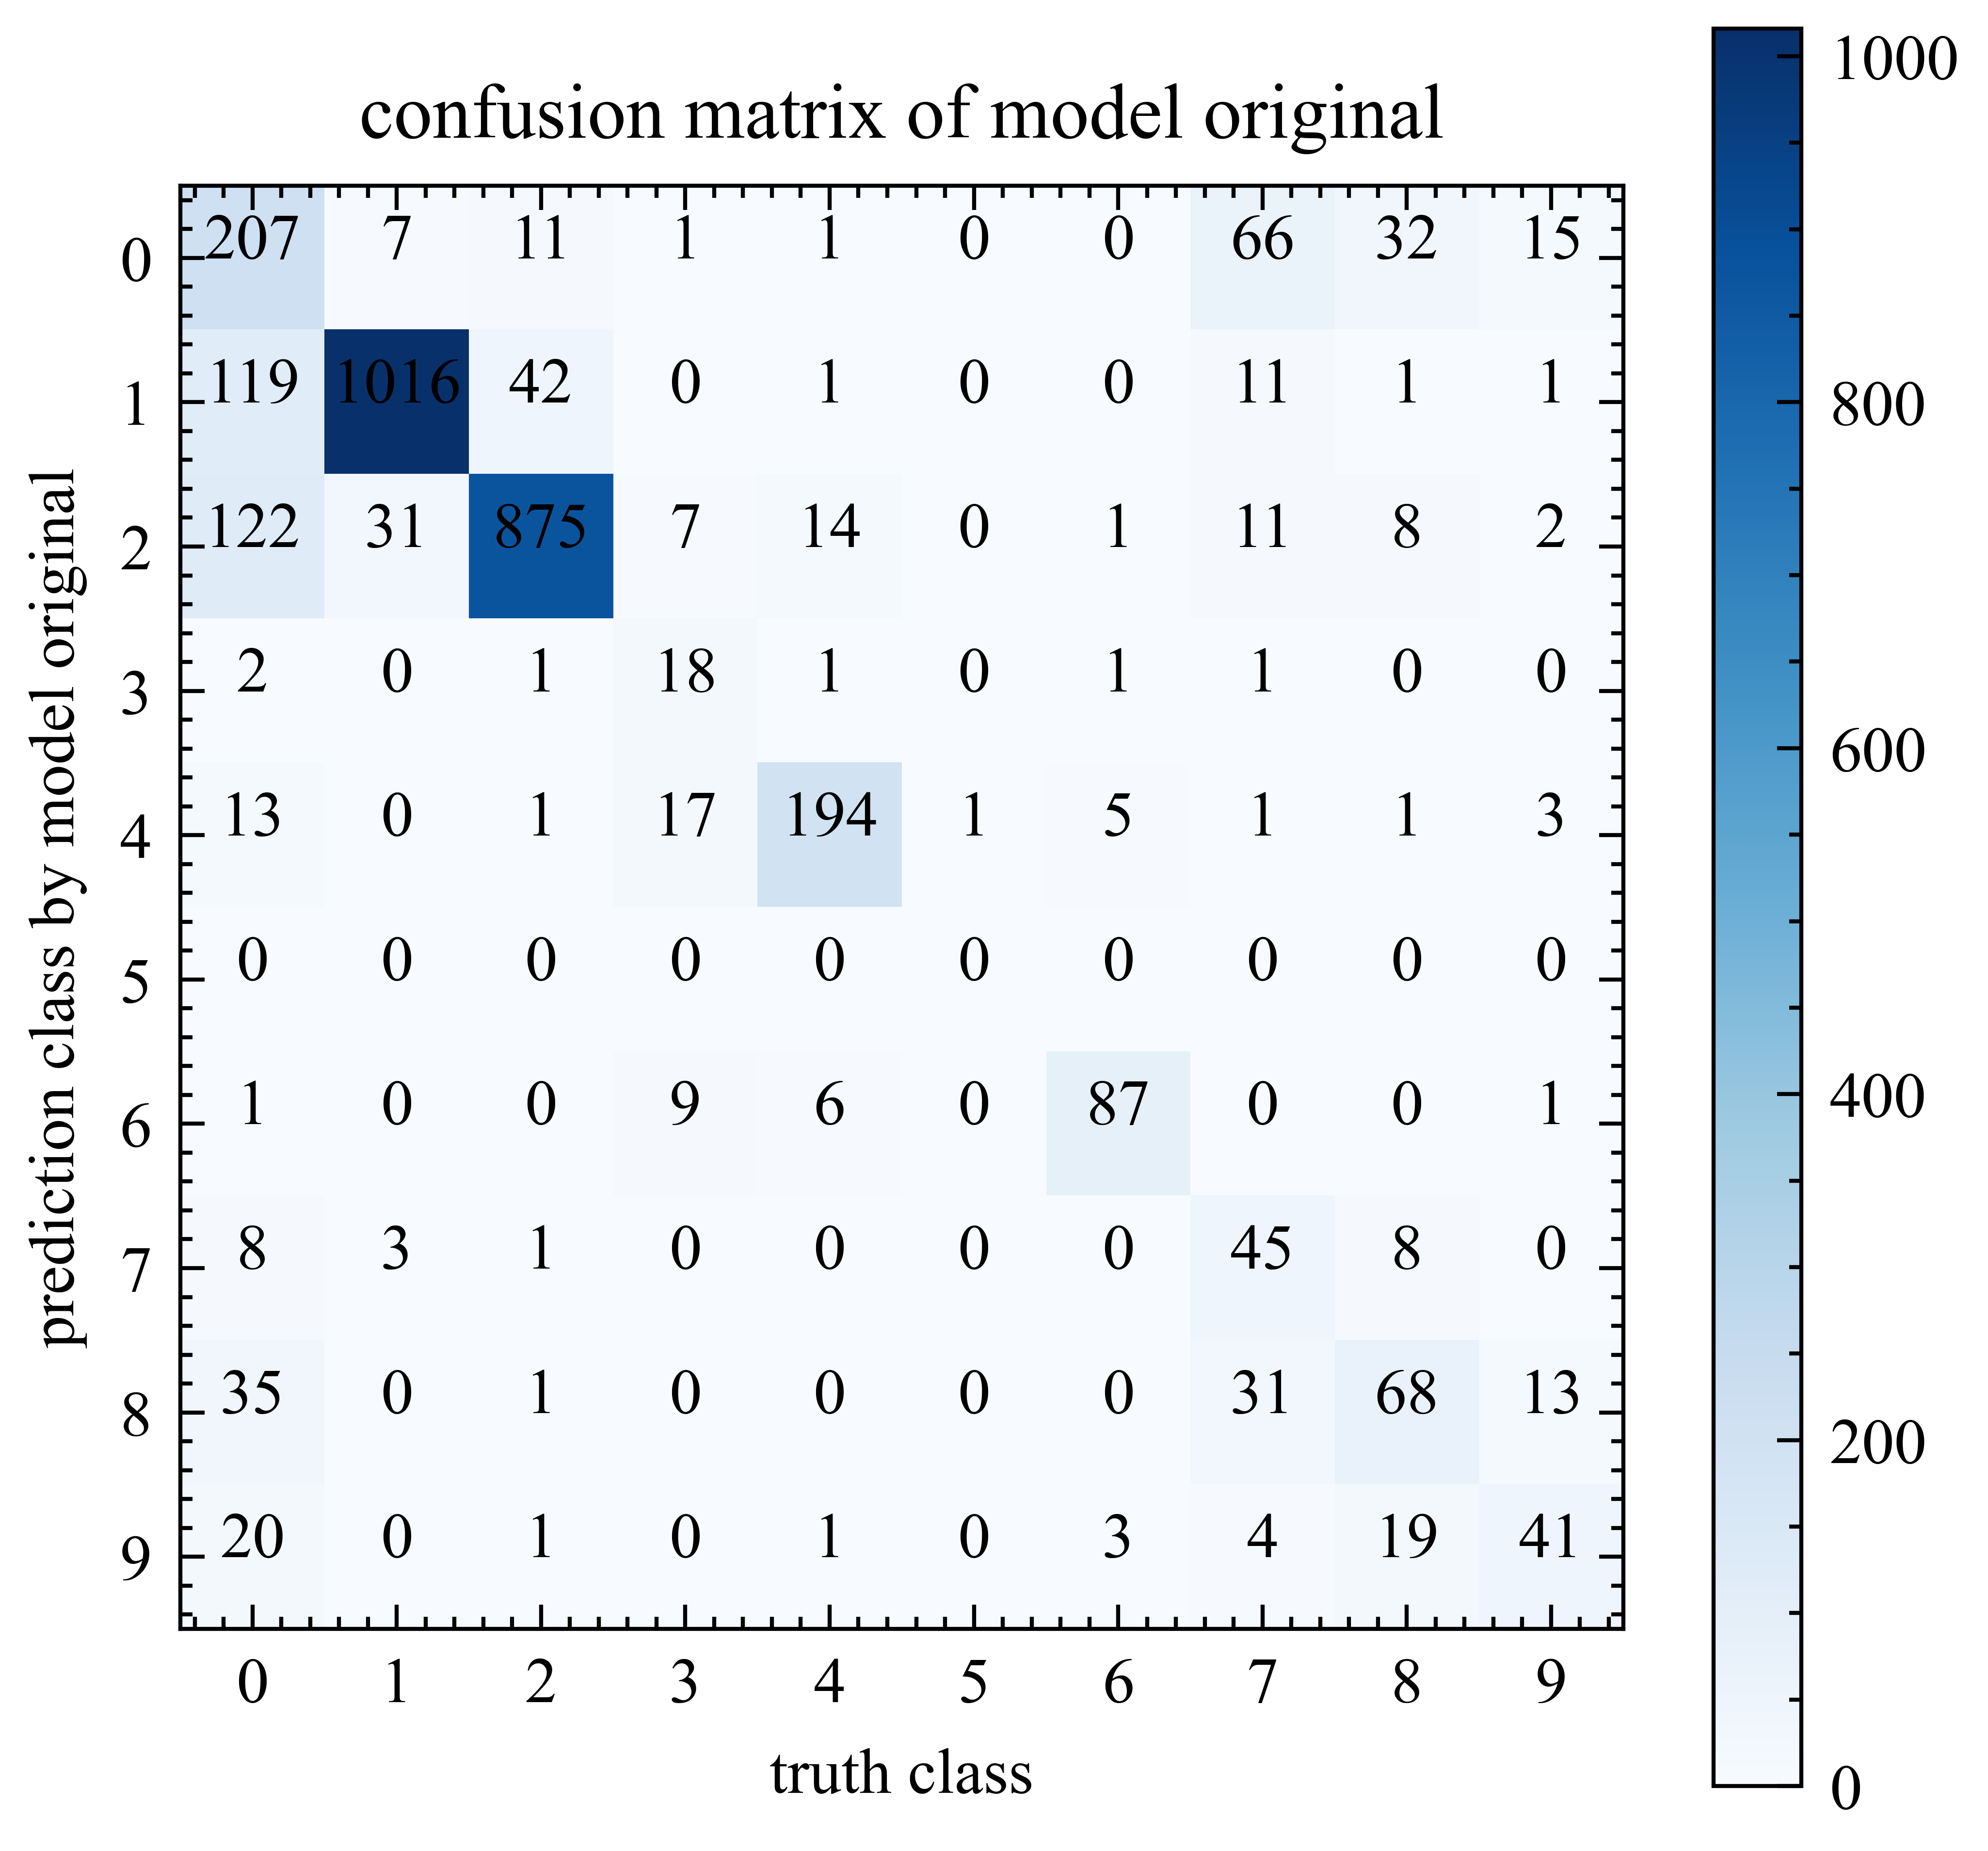

In [164]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], '.0f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix[i, j] > 0.5 else "black")
plt.title('confusion matrix of model original')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)


In [165]:
confusion_matrix_per = confusion_matrix.copy()

# create the confusion matrix
for i in range(10):
    confusion_matrix_per[i,:] /=np.sum(confusion_matrix,0)


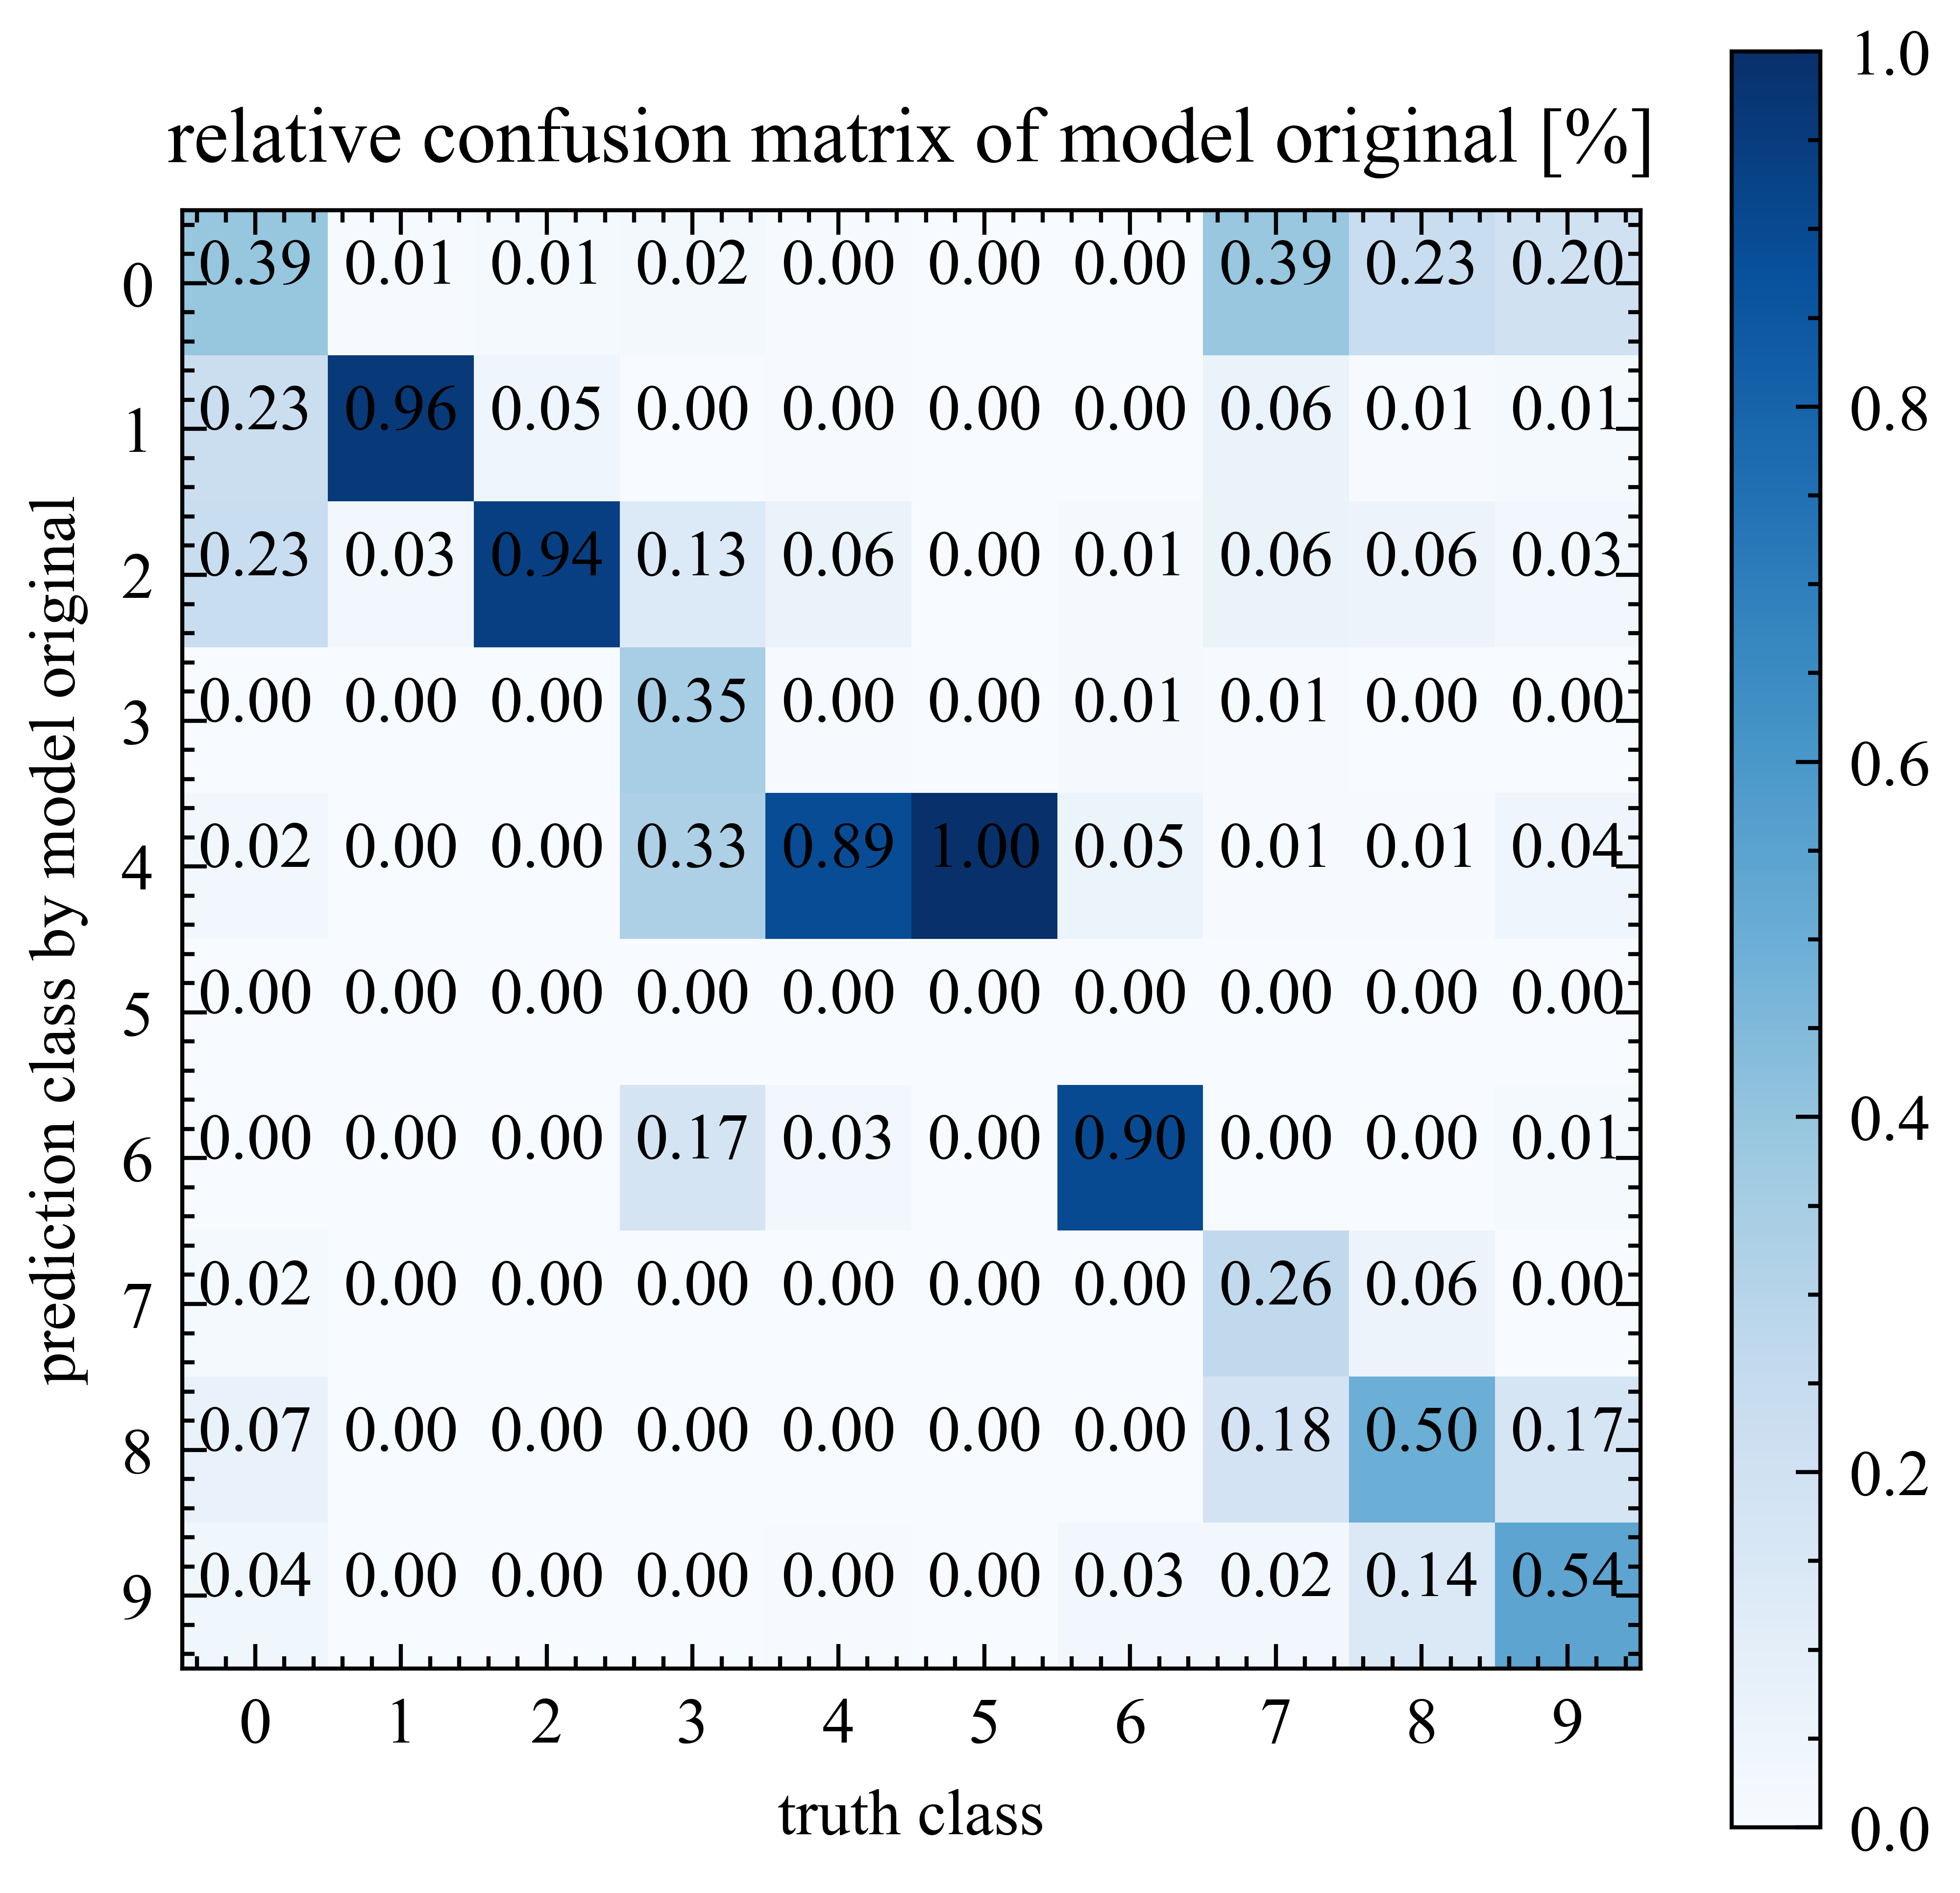

In [166]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix_per,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix_per[i, j], '.2f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix_per[i, j] > 0.5 else "black")
plt.title('relative confusion matrix of model original [%]')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

In [168]:
#缩小网络规模
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

# 定义基本块
def basic_block(x, filters, stride=1):
    print("Input shape:", x.shape)
    shortcut = x

    # 第一个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 第二个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果步幅不为 1，或输入和输出通道数不匹配，则需要对 shortcut 进行调整
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    print("Skip connection shape:", x.shape)

    # 添加 shortcut 到主路径上
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    print("Output shape:", x.shape)

    return x

# 定义 ResNet 结构
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # 堆叠残差块
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)

    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128, stride=1)
    x = basic_block(x, filters=128, stride=1)
    #x = basic_block(x, filters=128, stride=1)

    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)

    x = basic_block(x, filters=512, stride=2)
    x = basic_block(x, filters=512, stride=1)
    #x = basic_block(x, filters=512, stride=1)

    # 全局平均池化
    x = GlobalAveragePooling2D()(x)

    # 全连接层 增加了两层
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def prepare_data(train_images, train_labels, test_images, test_labels):
    
    trlabels=np.zeros(train_labels.shape[0])
    telabels=np.zeros(test_labels.shape[0])
   
    for i in range(train_labels.shape[0]):
        trlabels[i]=np.argmax(train_labels[i])
    for i in range(test_labels.shape[0]):
        telabels[i]=np.argmax(test_labels[i])
    
    return trlabels,  telabels

# 模型训练
def train_model():
    input_shape = (69, 69, 3)
    num_classes = 10

    
    model = ResNet(input_shape, num_classes)
    optimizer = Adam(learning_rate=0.001)

# 将优化器对象传入compile函数中
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
    
    # 训练模型并保存每个epoch的模型
    for epoch in range(20):  # 假设训练10个epoch
        model.fit(train_images, trlabels, batch_size=64, epochs=1, validation_data=(test_images, telabels))
        model.save(f'resnet_models_sparse/resnet_epoch_{epoch+1}.h5')

    #model.fit(train_images, trlabels, epochs=10, batch_size=32, validation_data=(test_images, telabels))

    return model



# 有没有模型
if not os.path.exists('resnet_models_sparse'):
    os.makedirs('resnet_models_sparse')



trained_model = train_model()



Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: 

In [184]:
# 模型测试
def test_model(model):
    
    loss, accuracy = model.evaluate(test_images, telabels)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    
#输出结果
def predict_image(test_images, telabels, model):
    
    predictions = model.predict(test_images)
    predicted_label=np.zeros(predictions.shape[0])
    for i in range(predictions.shape[0]):
        predicted_label[i] = np.argmax(predictions[i])
    return predicted_label


loaded_model = tf.keras.models.load_model('./resnet_models_sparse/resnet_epoch_14.h5')
trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
pre_labels=predict_image(test_images, telabels, loaded_model)


103/103 [==============================] - 4s 35ms/step


In [185]:
confusion_matrix = np.zeros((10,10))

# create the confusion matrix
for i in range(telabels.shape[0]):
    confusion_matrix[int(pre_labels[i]),int(telabels[i]) ] += 1


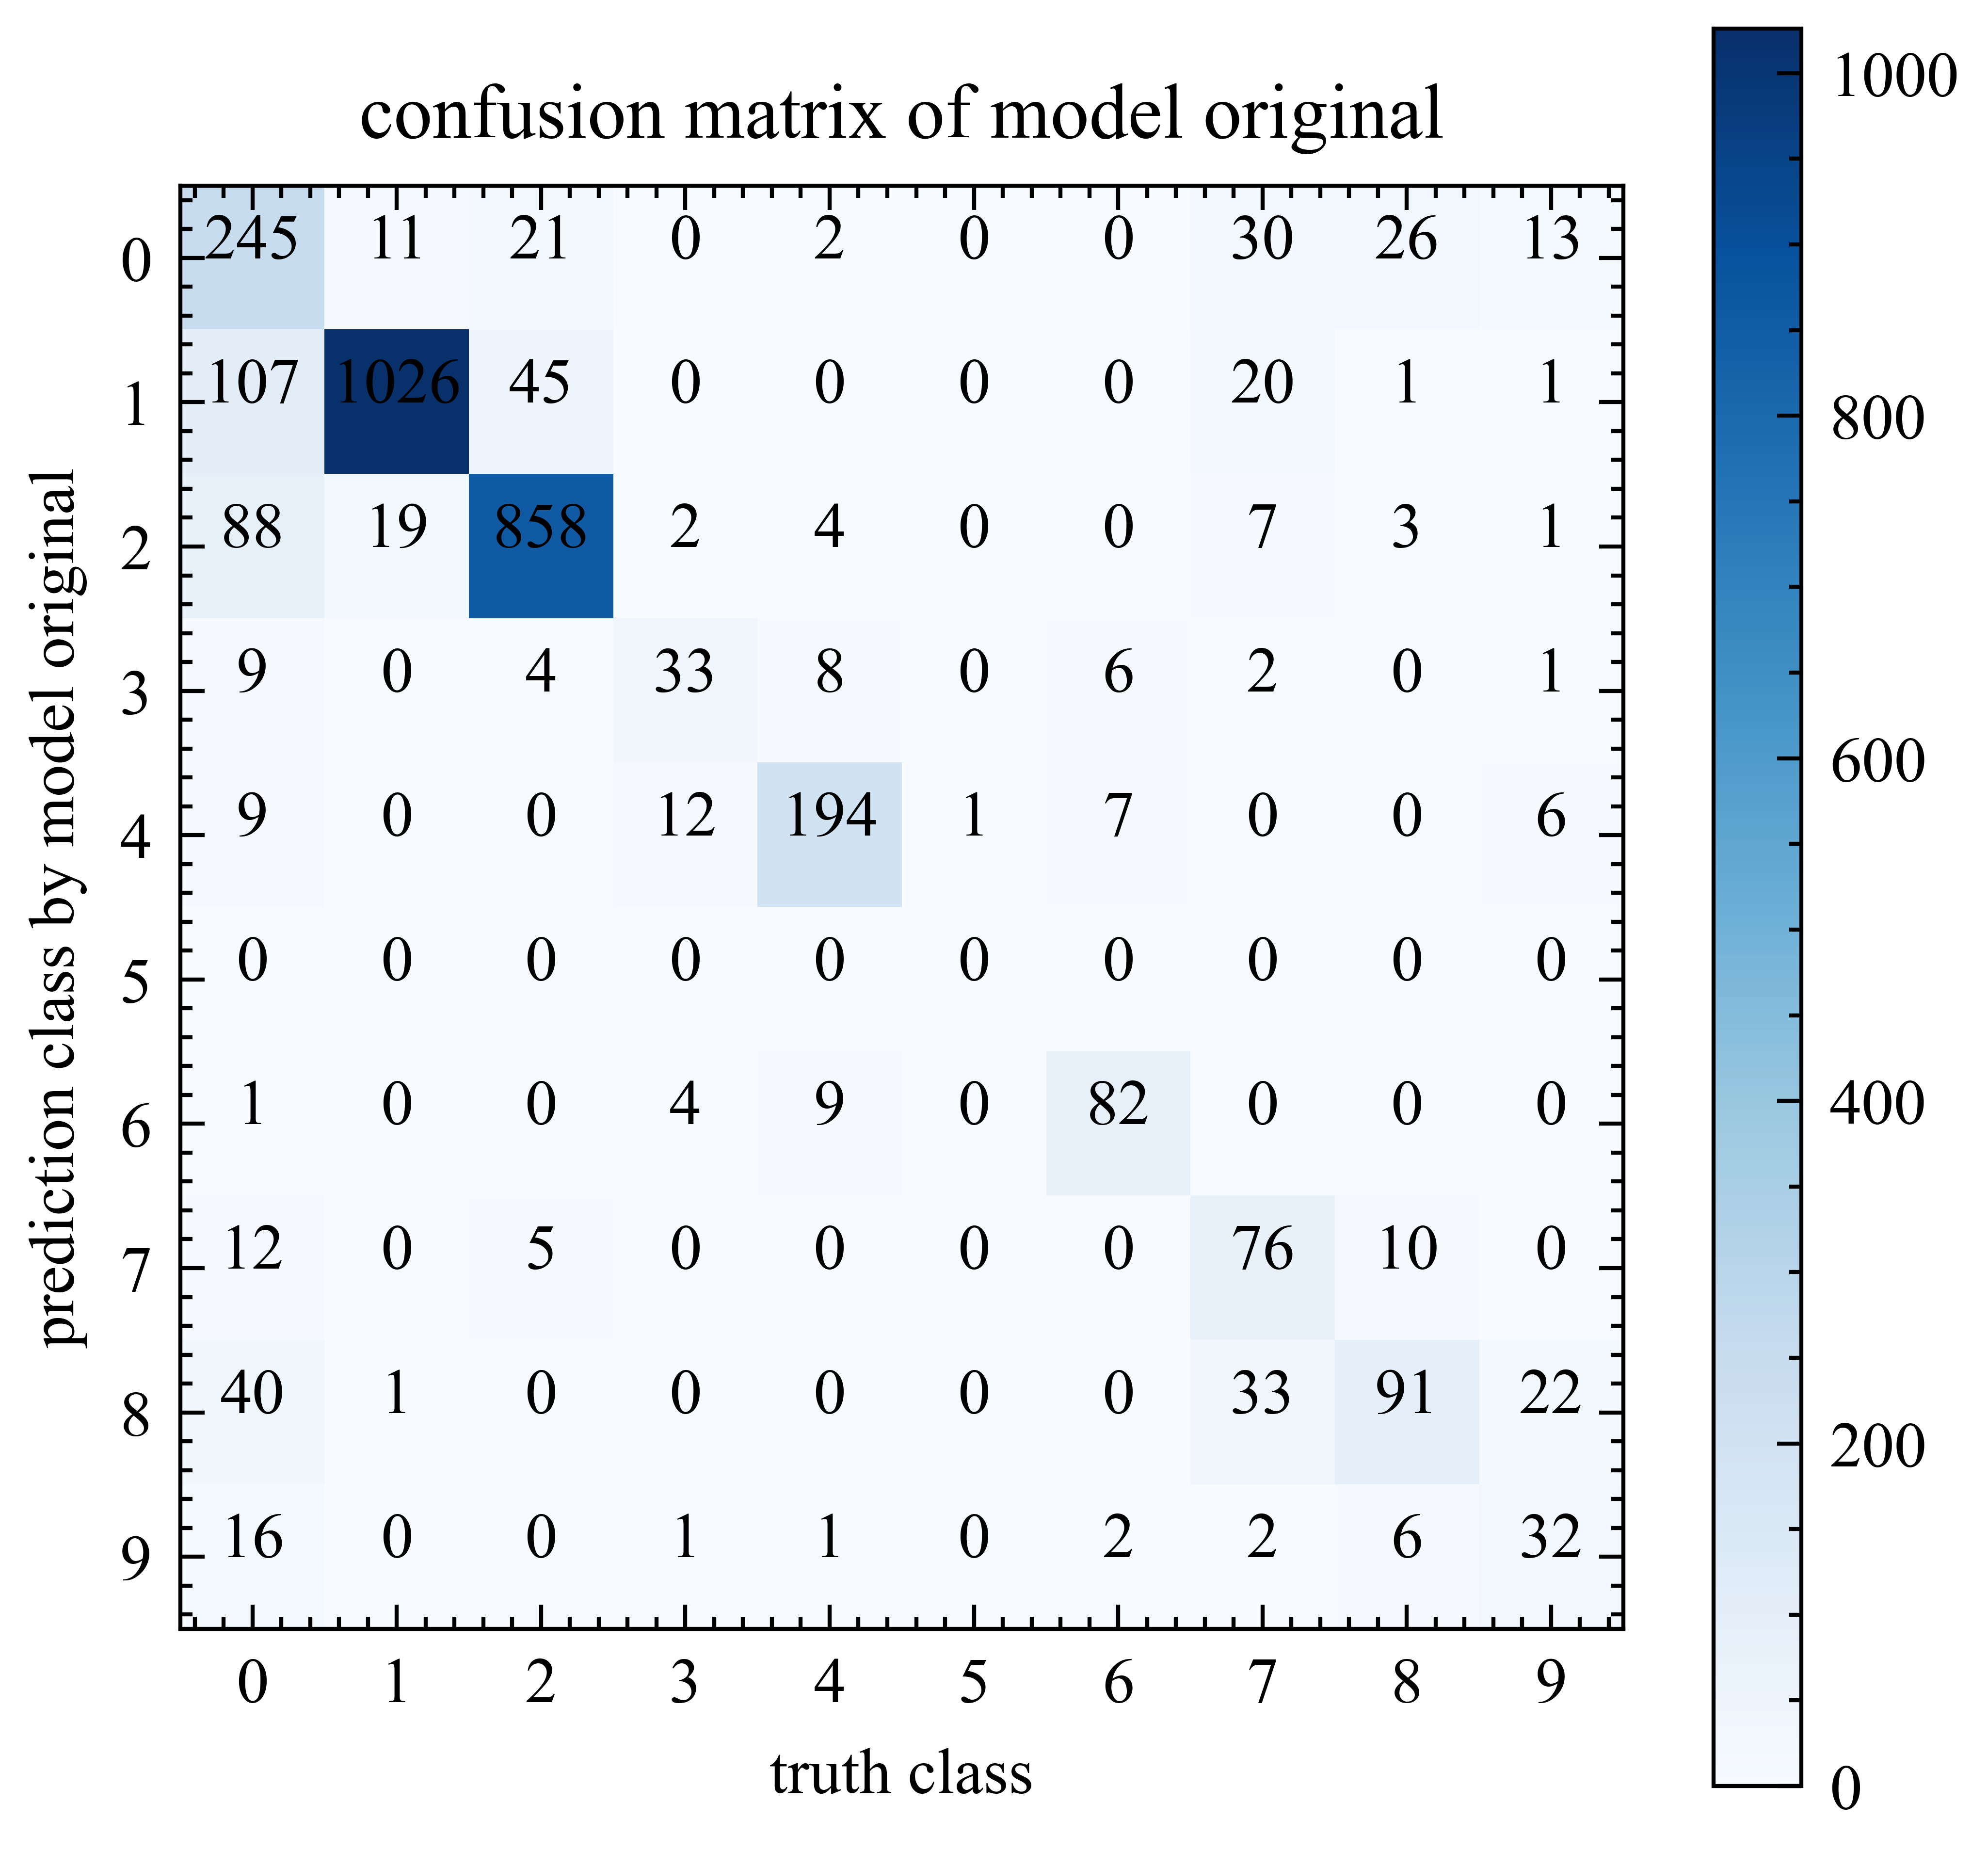

In [186]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], '.0f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix[i, j] > 0.5 else "black")
plt.title('confusion matrix of model original')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

In [187]:
confusion_matrix_per = confusion_matrix.copy()

# create the confusion matrix
for i in range(10):
    confusion_matrix_per[i,:] /=np.sum(confusion_matrix,0)


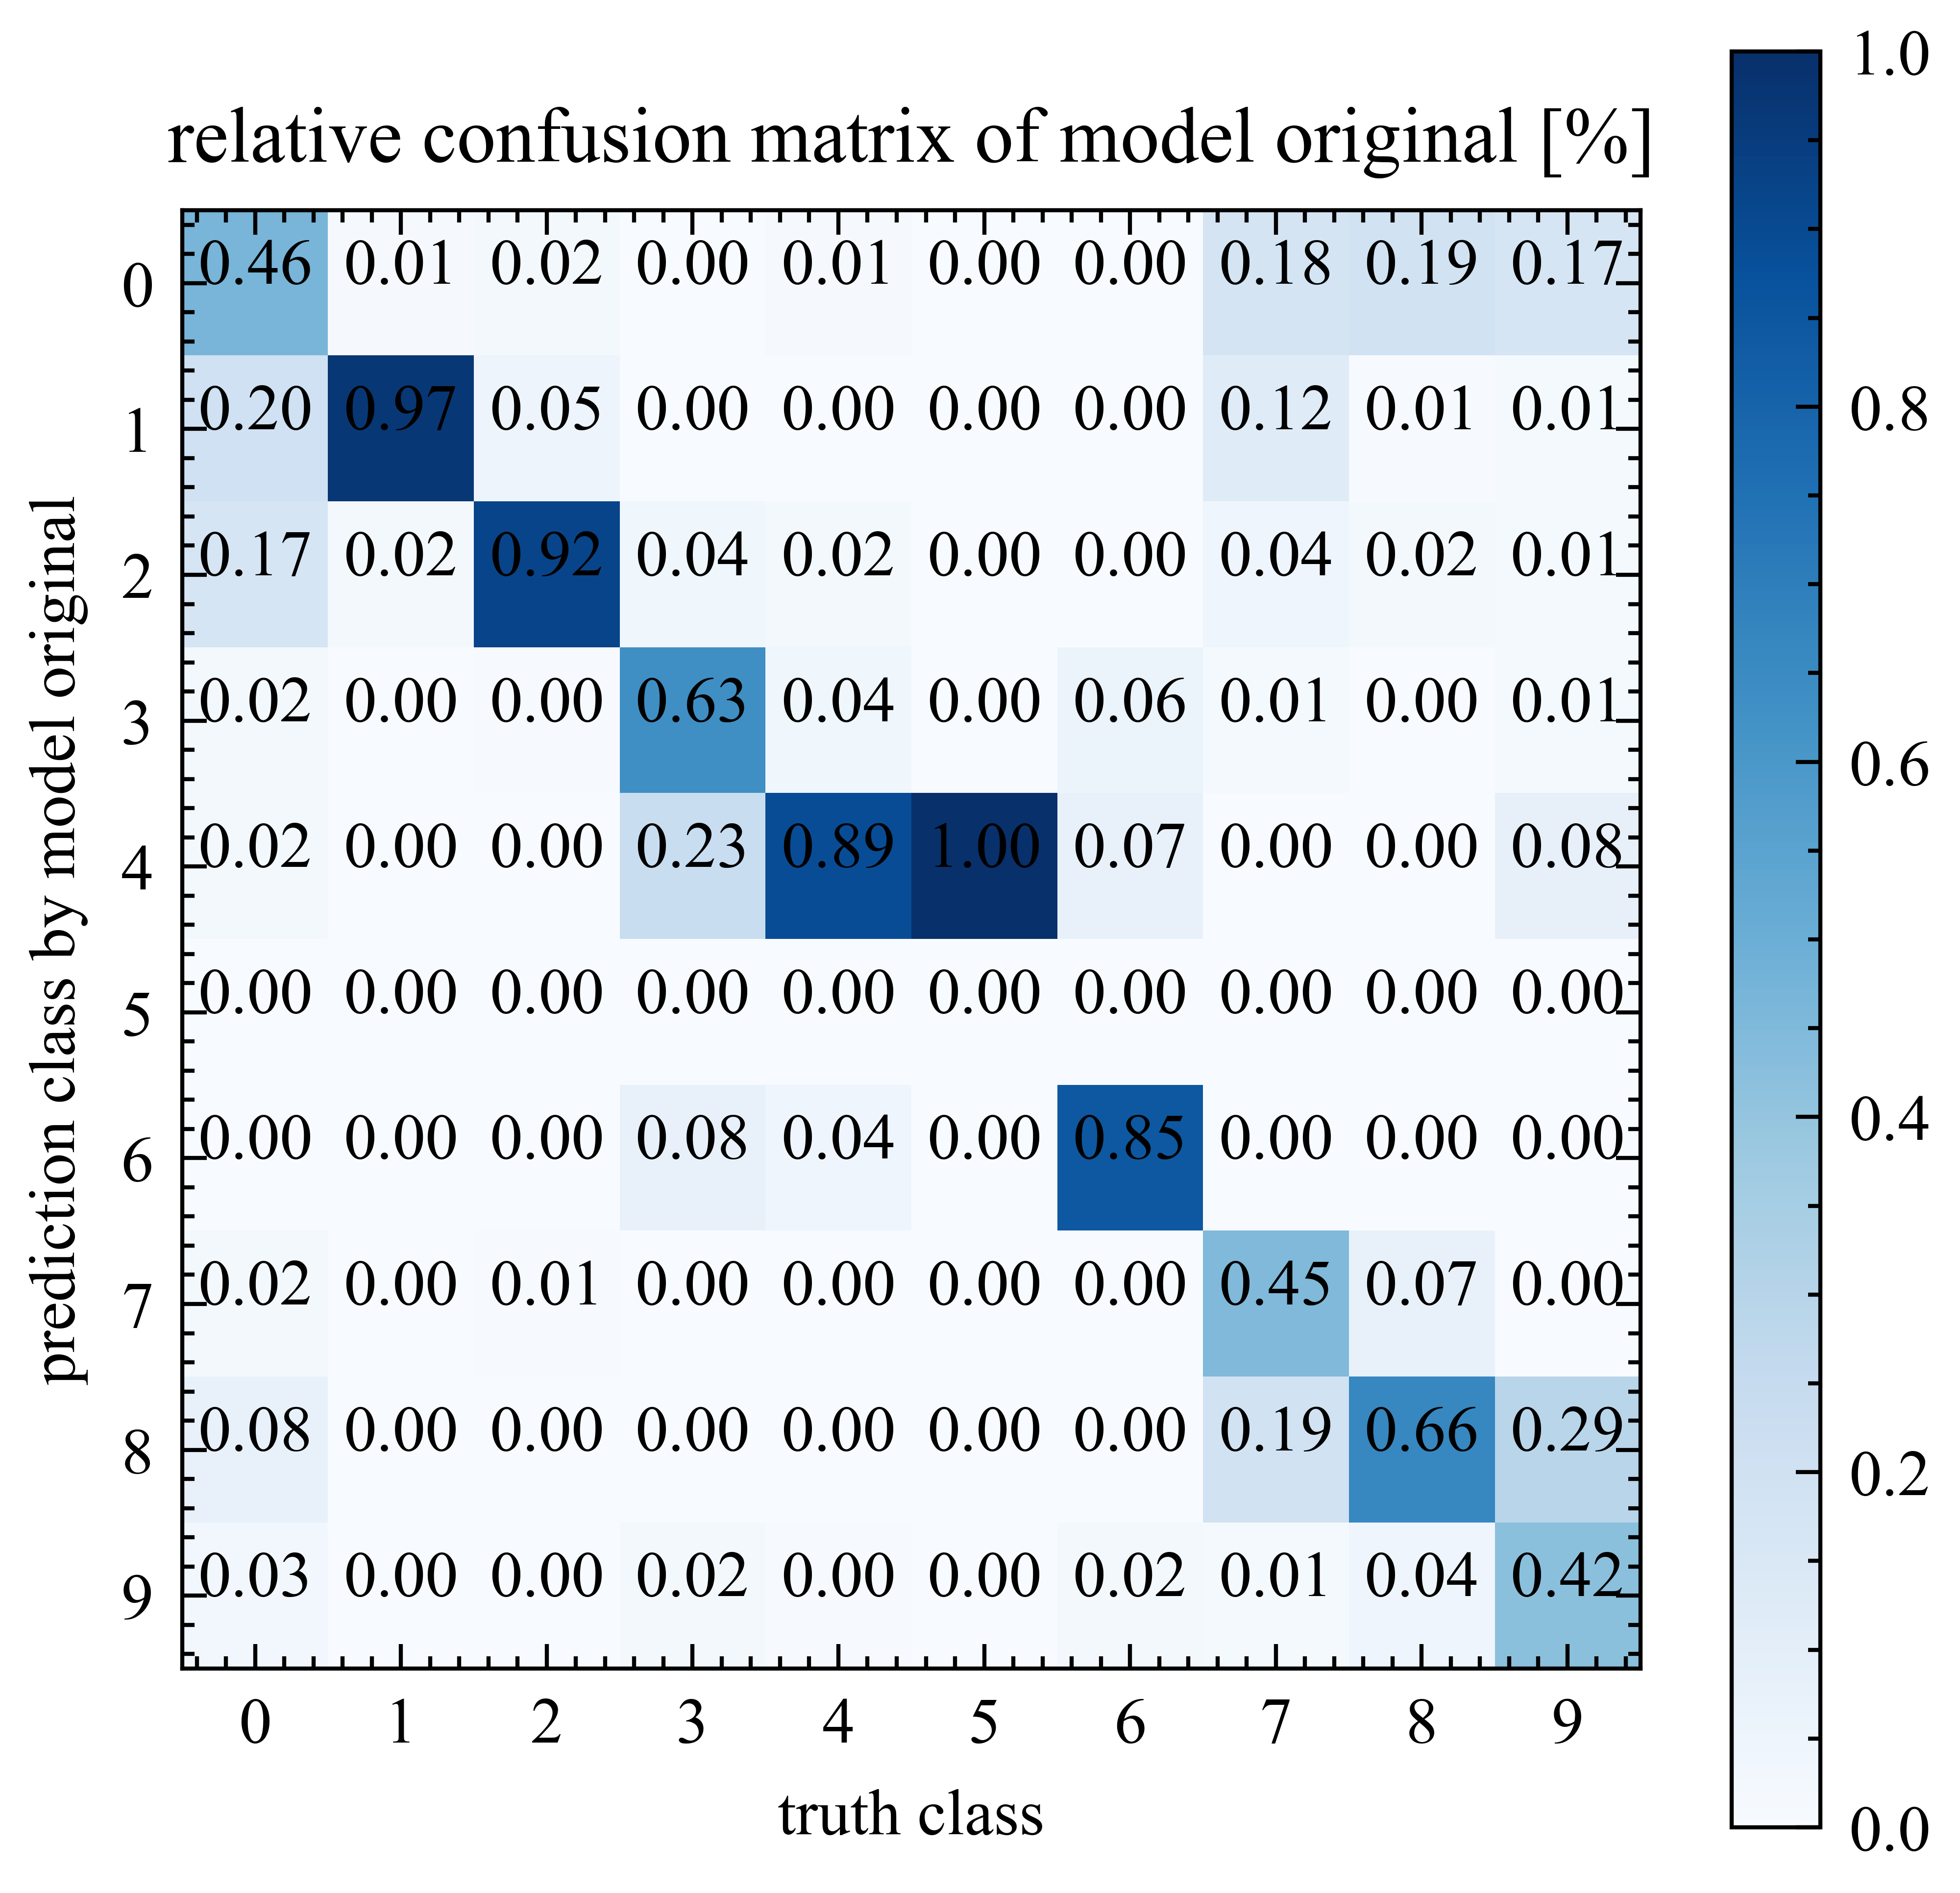

In [188]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix_per,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix_per[i, j], '.2f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix_per[i, j] > 0.5 else "black")
plt.title('relative confusion matrix of model original [%]')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

In [181]:
#进一步缩小网络规模，减小第一层卷积核

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

# 定义基本块
def basic_block(x, filters, stride=1):
    print("Input shape:", x.shape)
    shortcut = x

    # 第一个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 第二个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果步幅不为 1，或输入和输出通道数不匹配，则需要对 shortcut 进行调整
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    print("Skip connection shape:", x.shape)

    # 添加 shortcut 到主路径上
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    print("Output shape:", x.shape)

    return x

# 定义 ResNet 结构
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # 堆叠残差块
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)

    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128, stride=1)
    x = basic_block(x, filters=128, stride=1)
    #x = basic_block(x, filters=128, stride=1)

    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)

    #x = basic_block(x, filters=512, stride=2)
    #x = basic_block(x, filters=512, stride=1)
    #x = basic_block(x, filters=512, stride=1)

    # 全局平均池化
    x = GlobalAveragePooling2D()(x)

    # 全连接层 增加了两层
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def prepare_data(train_images, train_labels, test_images, test_labels):
    
    trlabels=np.zeros(train_labels.shape[0])
    telabels=np.zeros(test_labels.shape[0])
   
    for i in range(train_labels.shape[0]):
        trlabels[i]=np.argmax(train_labels[i])
    for i in range(test_labels.shape[0]):
        telabels[i]=np.argmax(test_labels[i])
    
    return trlabels,  telabels

# 模型训练
def train_model():
    input_shape = (69, 69, 3)
    num_classes = 10

    
    model = ResNet(input_shape, num_classes)
    optimizer = Adam(learning_rate=0.001)

# 将优化器对象传入compile函数中
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
    
    # 训练模型并保存每个epoch的模型
    for epoch in range(20):  # 假设训练10个epoch
        model.fit(train_images, trlabels, batch_size=64, epochs=1, validation_data=(test_images, telabels))
        model.save(f'resnet_models_sparse2/resnet_epoch_{epoch+1}.h5')

    #model.fit(train_images, trlabels, epochs=10, batch_size=32, validation_data=(test_images, telabels))

    return model



# 有没有模型
if not os.path.exists('resnet_models_sparse2'):
    os.makedirs('resnet_models_sparse2')



trained_model = train_model()



Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: 

In [189]:
# 模型测试
def test_model(model):
    
    loss, accuracy = model.evaluate(test_images, telabels)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    
#输出结果
def predict_image(test_images, telabels, model):
    
    predictions = model.predict(test_images)
    predicted_label=np.zeros(predictions.shape[0])
    for i in range(predictions.shape[0]):
        predicted_label[i] = np.argmax(predictions[i])
    return predicted_label


loaded_model = tf.keras.models.load_model('./resnet_models_sparse2/resnet_epoch_13.h5')
trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
pre_labels=predict_image(test_images, telabels, loaded_model)


103/103 [==============================] - 4s 36ms/step


In [190]:
confusion_matrix = np.zeros((10,10))

# create the confusion matrix
for i in range(telabels.shape[0]):
    confusion_matrix[int(pre_labels[i]),int(telabels[i]) ] += 1


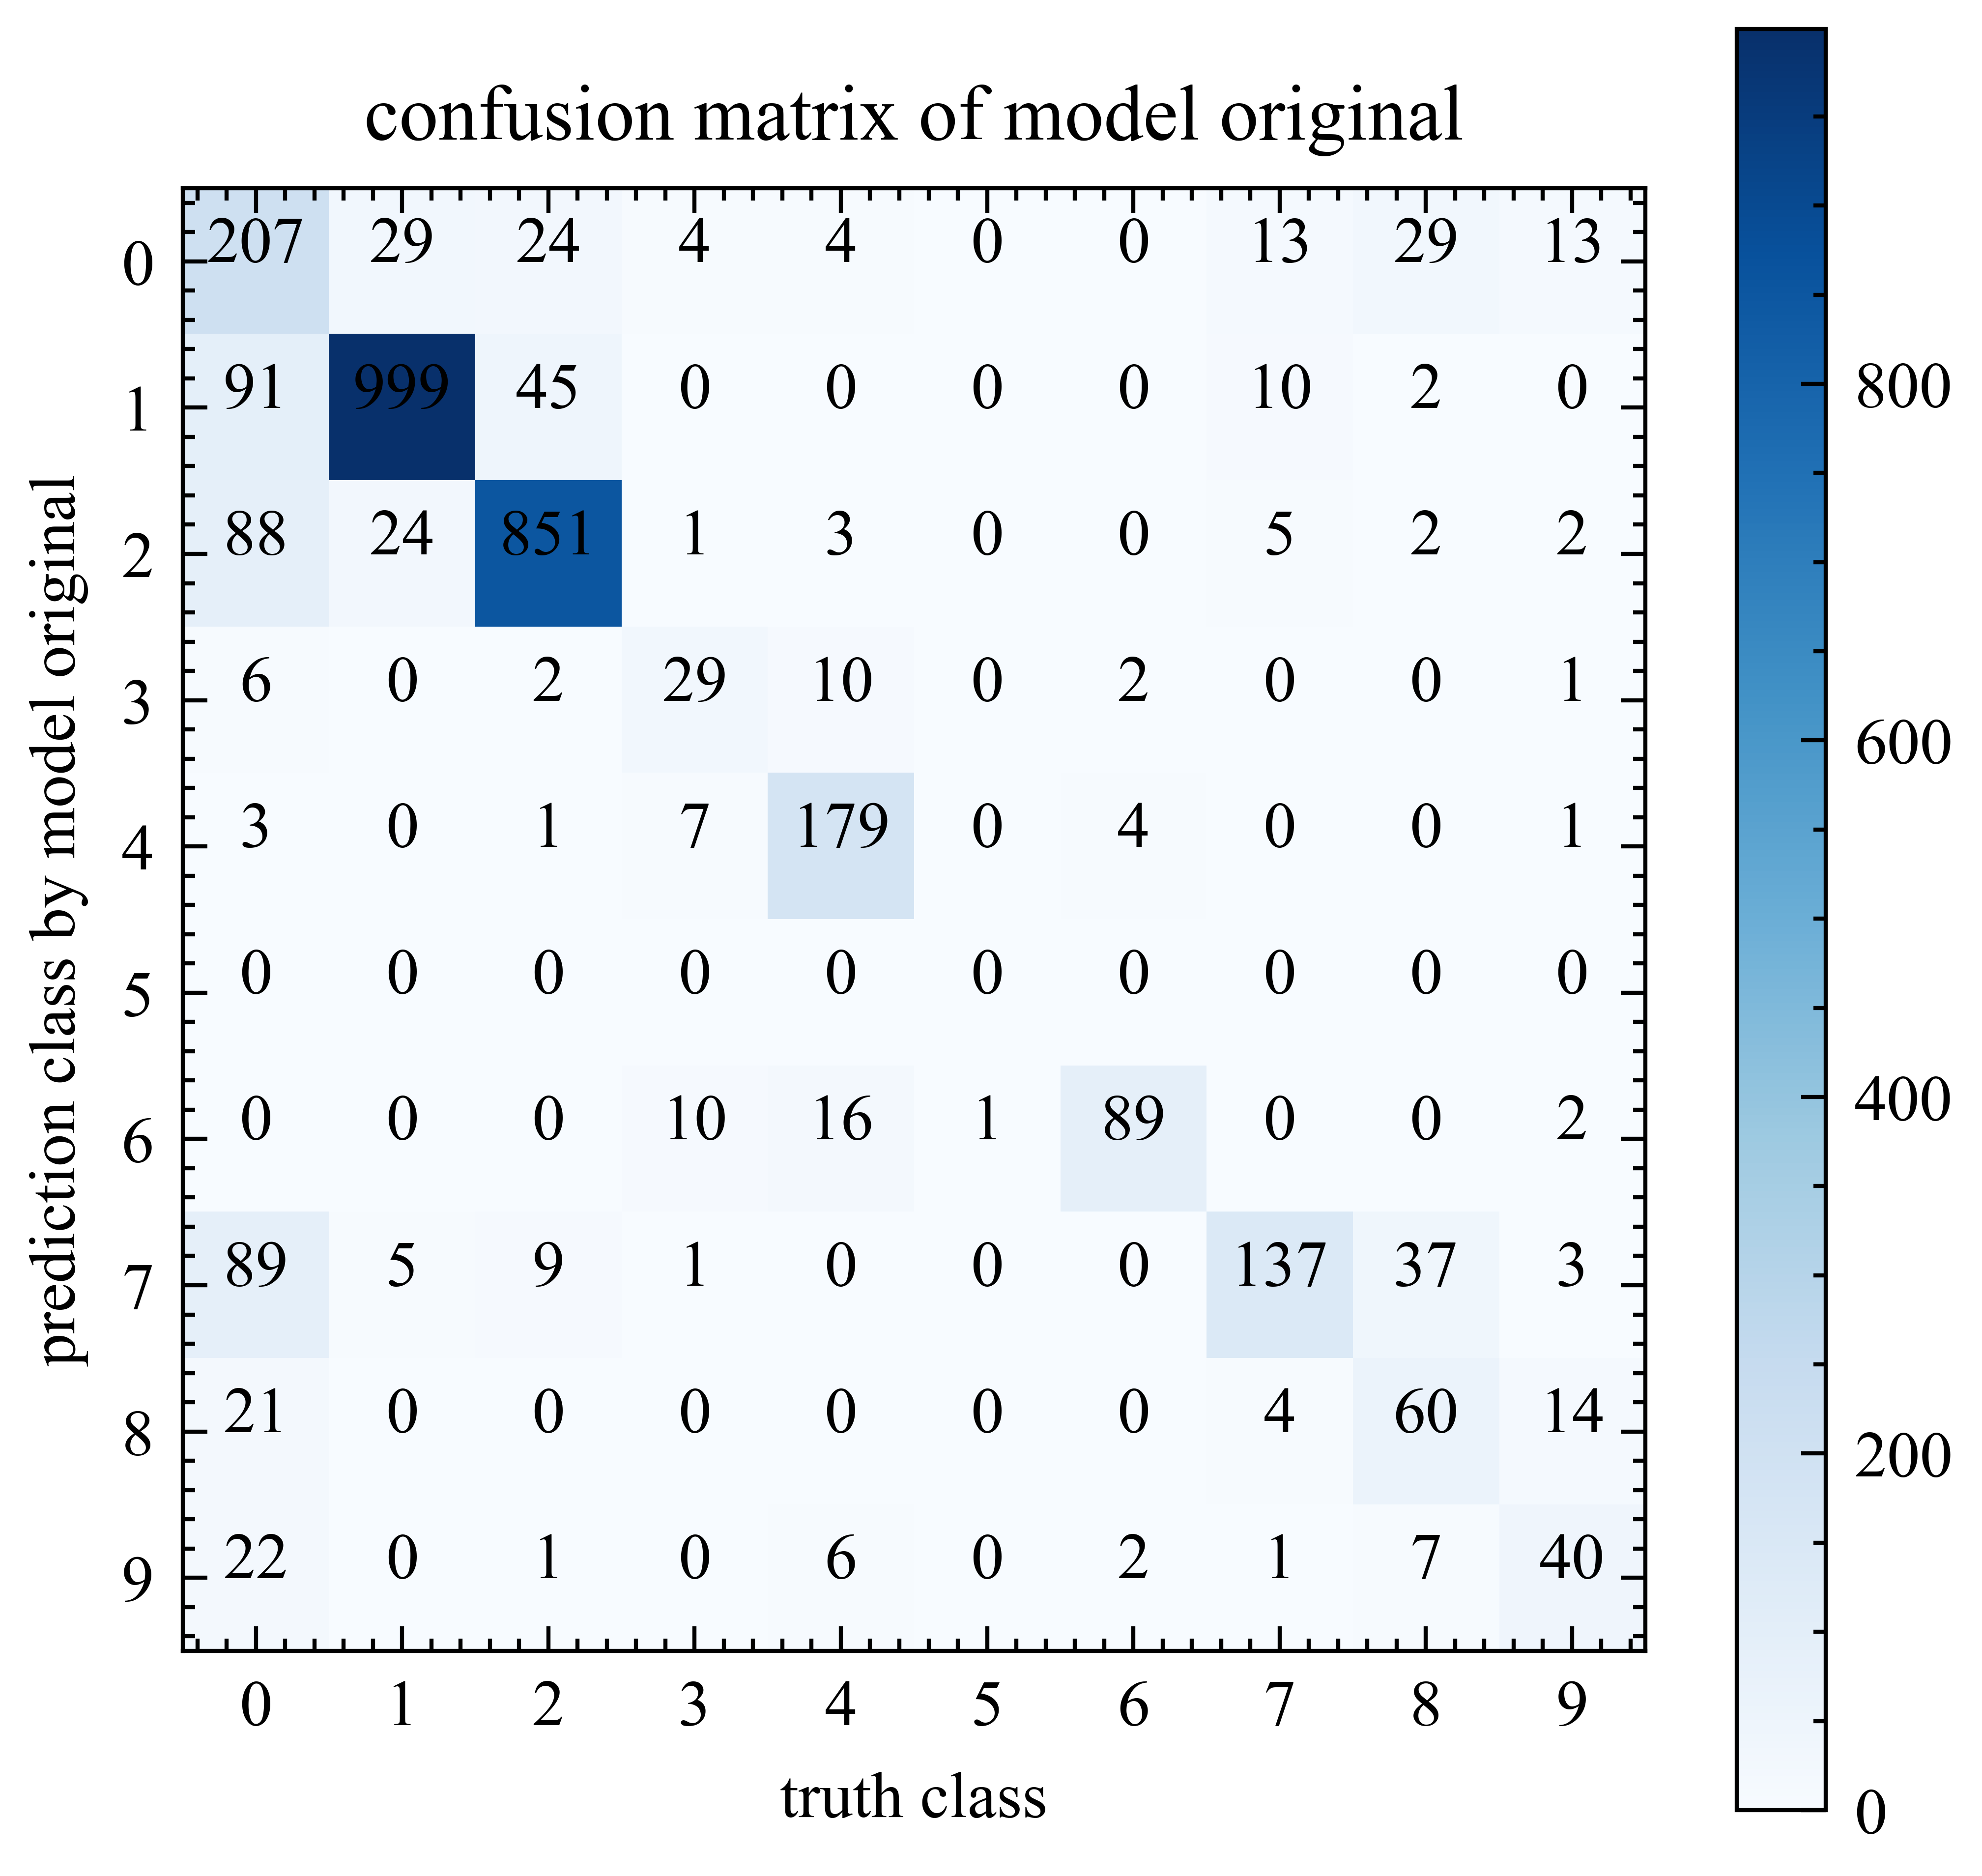

In [191]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], '.0f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix[i, j] > 0.5 else "black")
plt.title('confusion matrix of model original')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

In [192]:
confusion_matrix_per = confusion_matrix.copy()

# create the confusion matrix
for i in range(10):
    confusion_matrix_per[i,:] /=np.sum(confusion_matrix,0)


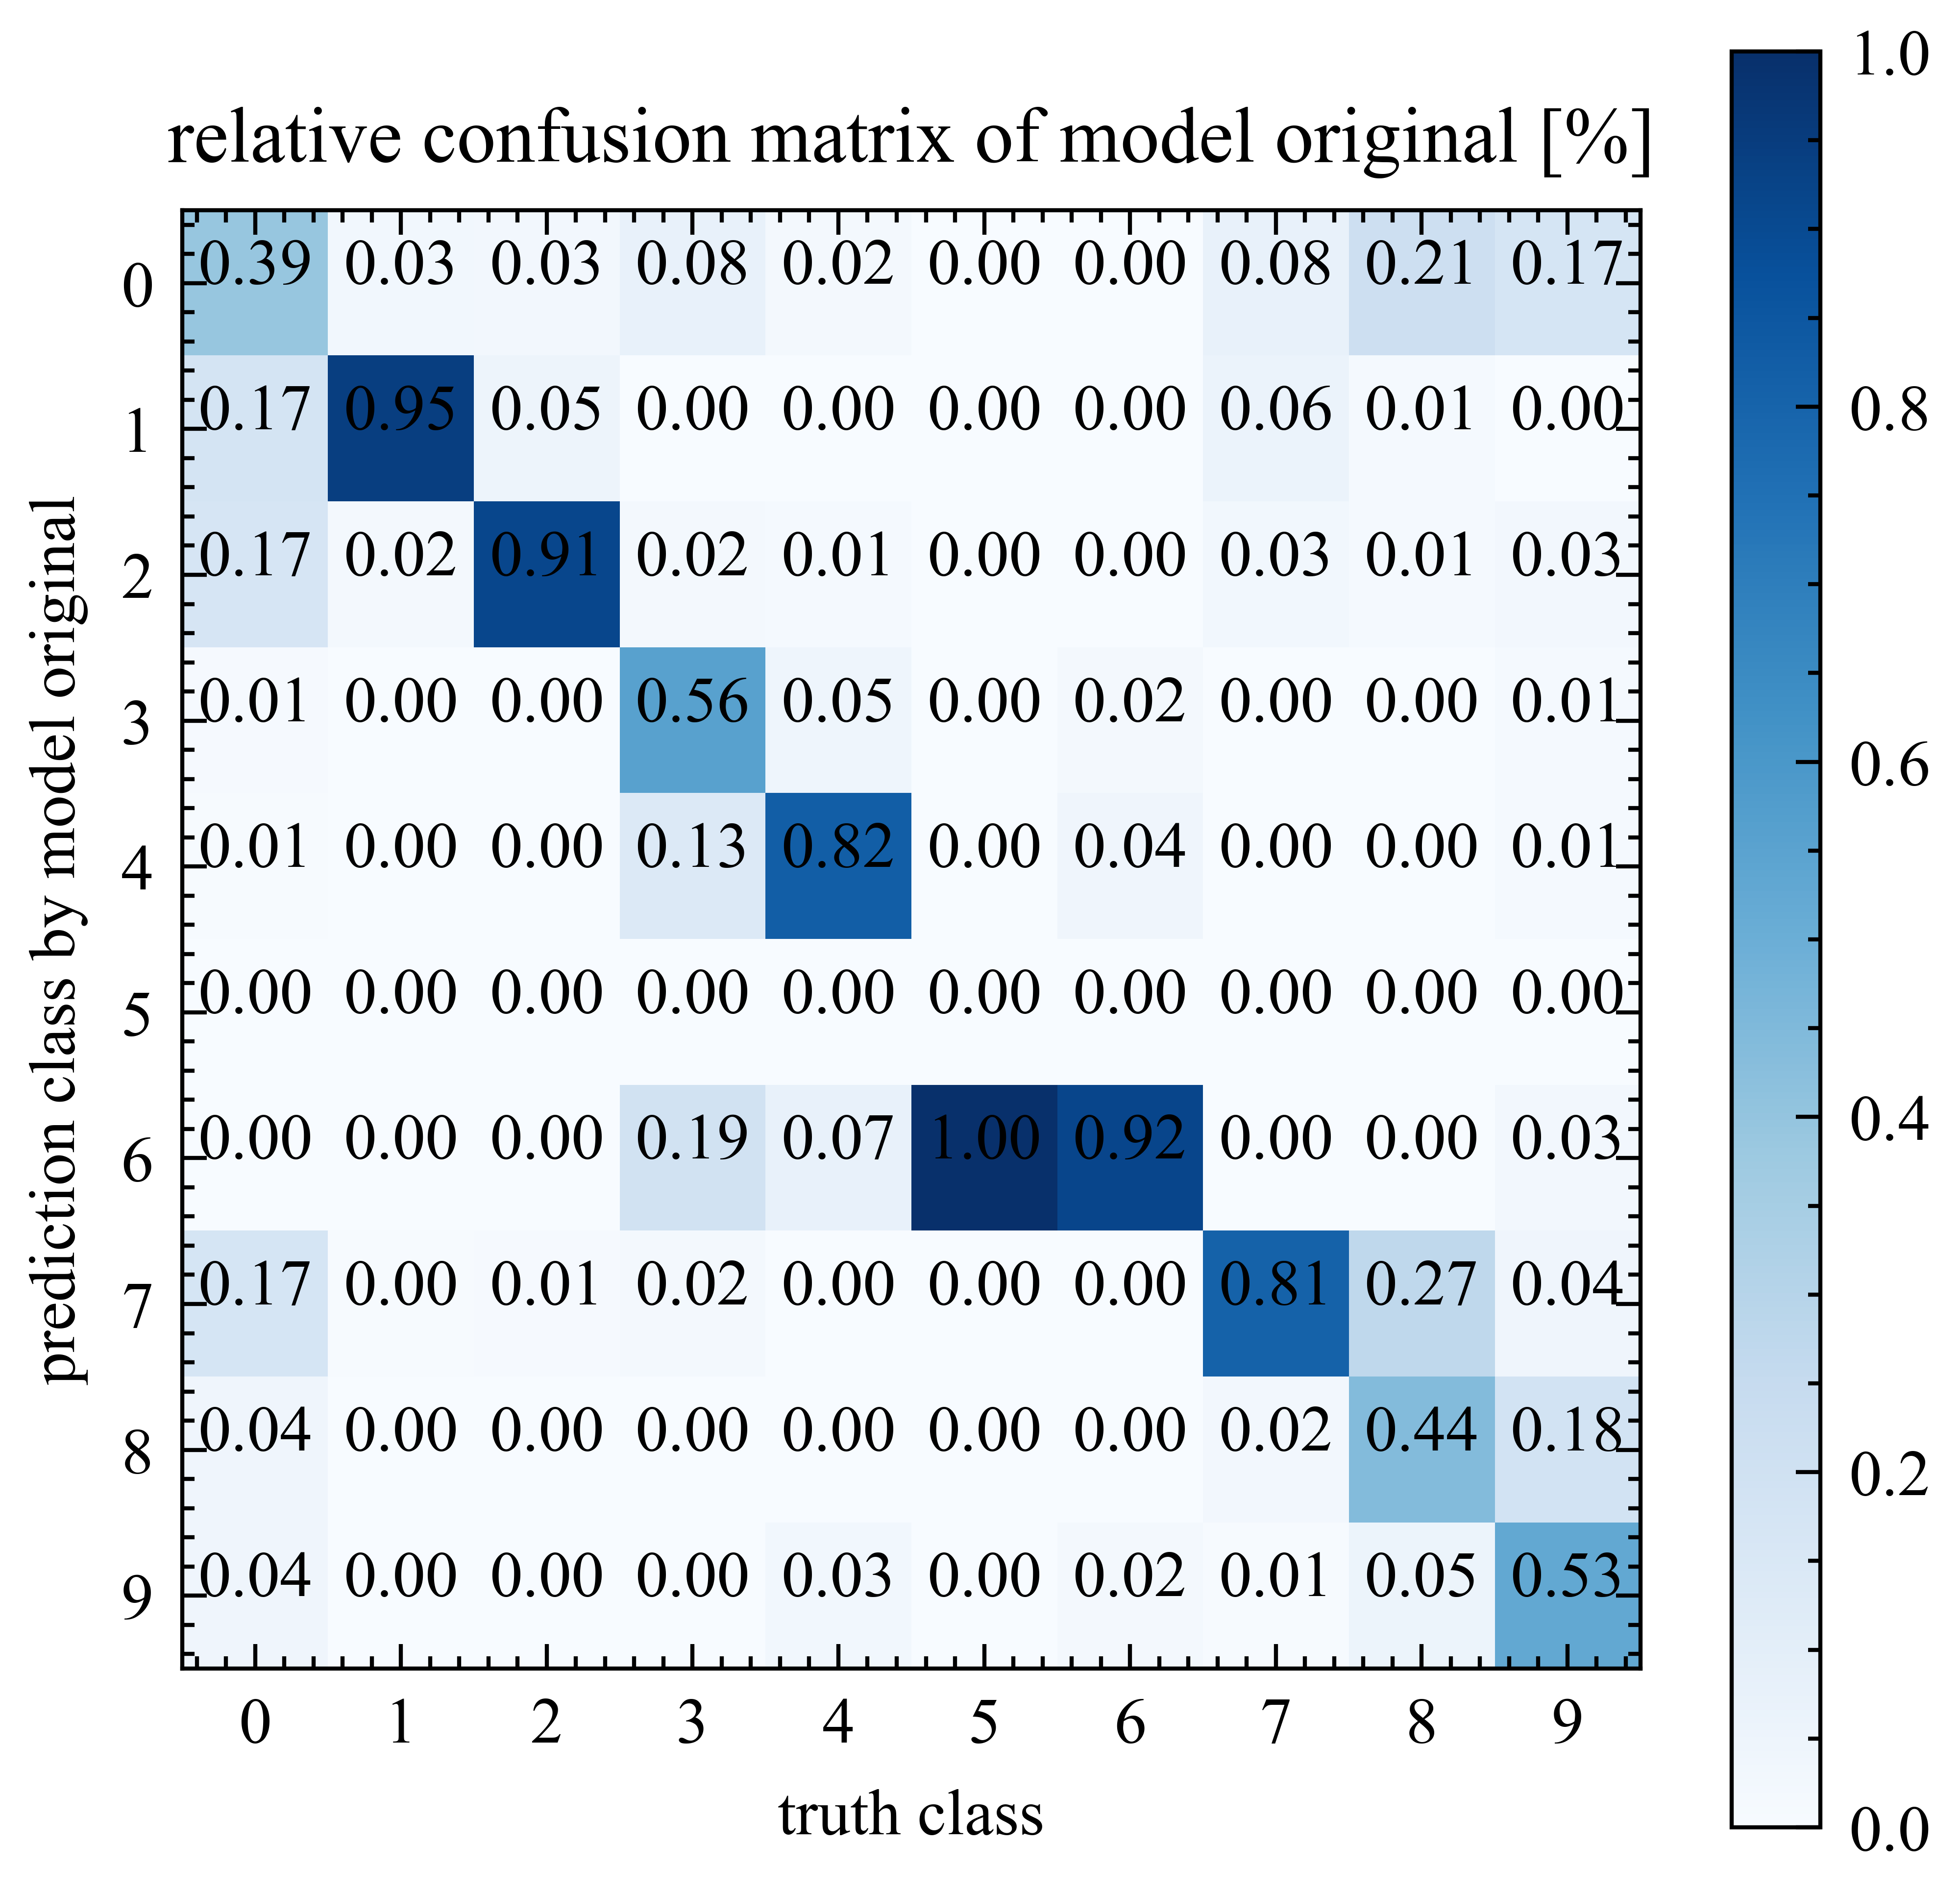

In [193]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix_per,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix_per[i, j], '.2f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix_per[i, j] > 0.5 else "black")
plt.title('relative confusion matrix of model original [%]')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

In [194]:
#再小一点

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

# 定义基本块
def basic_block(x, filters, stride=1):
    print("Input shape:", x.shape)
    shortcut = x

    # 第一个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 第二个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果步幅不为 1，或输入和输出通道数不匹配，则需要对 shortcut 进行调整
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    print("Skip connection shape:", x.shape)

    # 添加 shortcut 到主路径上
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    print("Output shape:", x.shape)

    return x

# 定义 ResNet 结构
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # 堆叠残差块
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)

    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128, stride=1)
    x = basic_block(x, filters=128, stride=1)
    #x = basic_block(x, filters=128, stride=1)

    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)

    #x = basic_block(x, filters=512, stride=2)
    #x = basic_block(x, filters=512, stride=1)
    #x = basic_block(x, filters=512, stride=1)

    # 全局平均池化
    x = GlobalAveragePooling2D()(x)

    # 全连接层 增加了两层
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    #x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def prepare_data(train_images, train_labels, test_images, test_labels):
    
    trlabels=np.zeros(train_labels.shape[0])
    telabels=np.zeros(test_labels.shape[0])
   
    for i in range(train_labels.shape[0]):
        trlabels[i]=np.argmax(train_labels[i])
    for i in range(test_labels.shape[0]):
        telabels[i]=np.argmax(test_labels[i])
    
    return trlabels,  telabels

# 模型训练
def train_model():
    input_shape = (69, 69, 3)
    num_classes = 10

    
    model = ResNet(input_shape, num_classes)
    optimizer = Adam(learning_rate=0.001)

# 将优化器对象传入compile函数中
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
    
    # 训练模型并保存每个epoch的模型
    for epoch in range(20):  # 假设训练10个epoch
        model.fit(train_images, trlabels, batch_size=64, epochs=1, validation_data=(test_images, telabels))
        model.save(f'resnet_models_sparse3/resnet_epoch_{epoch+1}.h5')

    #model.fit(train_images, trlabels, epochs=10, batch_size=32, validation_data=(test_images, telabels))

    return model



# 有没有模型
if not os.path.exists('resnet_models_sparse3'):
    os.makedirs('resnet_models_sparse3')



trained_model = train_model()



Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
290/290 [==============================] - 41s 141ms/s

In [195]:
# 模型测试
def test_model(model):
    
    loss, accuracy = model.evaluate(test_images, telabels)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    
#输出结果
def predict_image(test_images, telabels, model):
    
    predictions = model.predict(test_images)
    predicted_label=np.zeros(predictions.shape[0])
    for i in range(predictions.shape[0]):
        predicted_label[i] = np.argmax(predictions[i])
    return predicted_label


loaded_model = tf.keras.models.load_model('./resnet_models_sparse3/resnet_epoch_8.h5')
trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
pre_labels=predict_image(test_images, telabels, loaded_model)


103/103 [==============================] - 5s 39ms/step


In [196]:
confusion_matrix = np.zeros((10,10))

# create the confusion matrix
for i in range(telabels.shape[0]):
    confusion_matrix[int(pre_labels[i]),int(telabels[i]) ] += 1

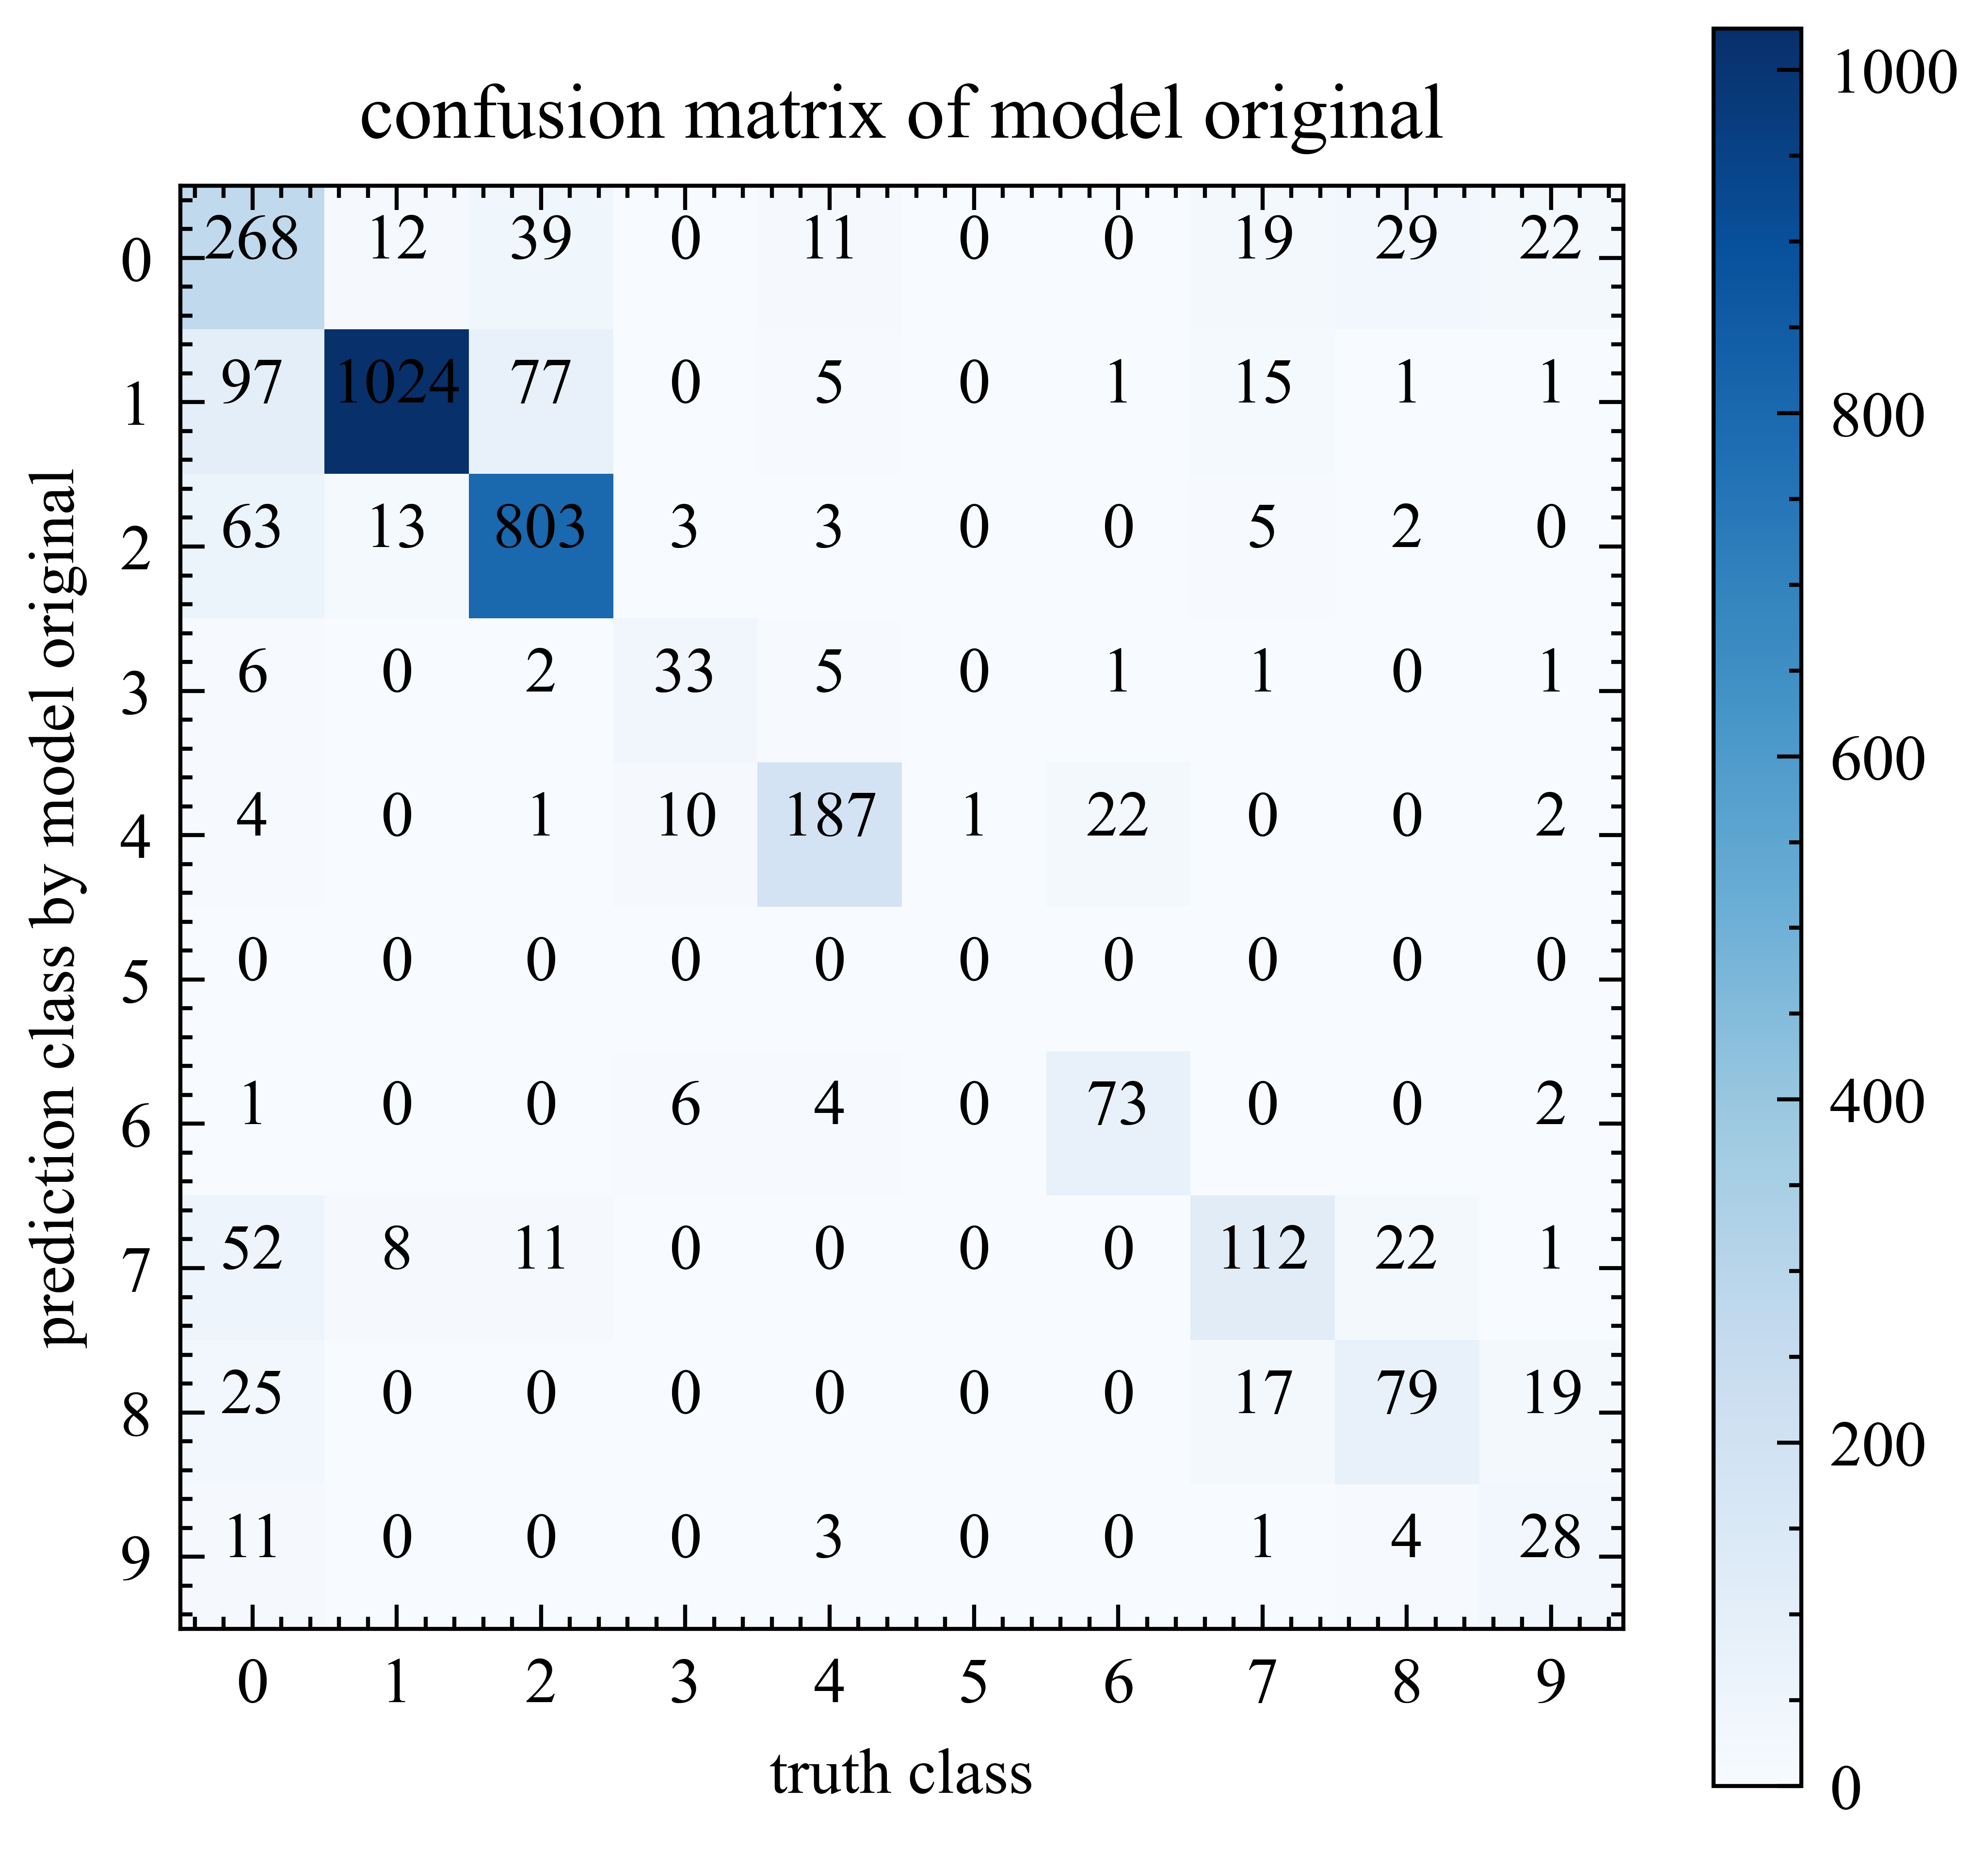

In [197]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], '.0f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix[i, j] > 0.5 else "black")
plt.title('confusion matrix of model original')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

In [198]:
confusion_matrix_per = confusion_matrix.copy()

# create the confusion matrix
for i in range(10):
    confusion_matrix_per[i,:] /=np.sum(confusion_matrix,0)


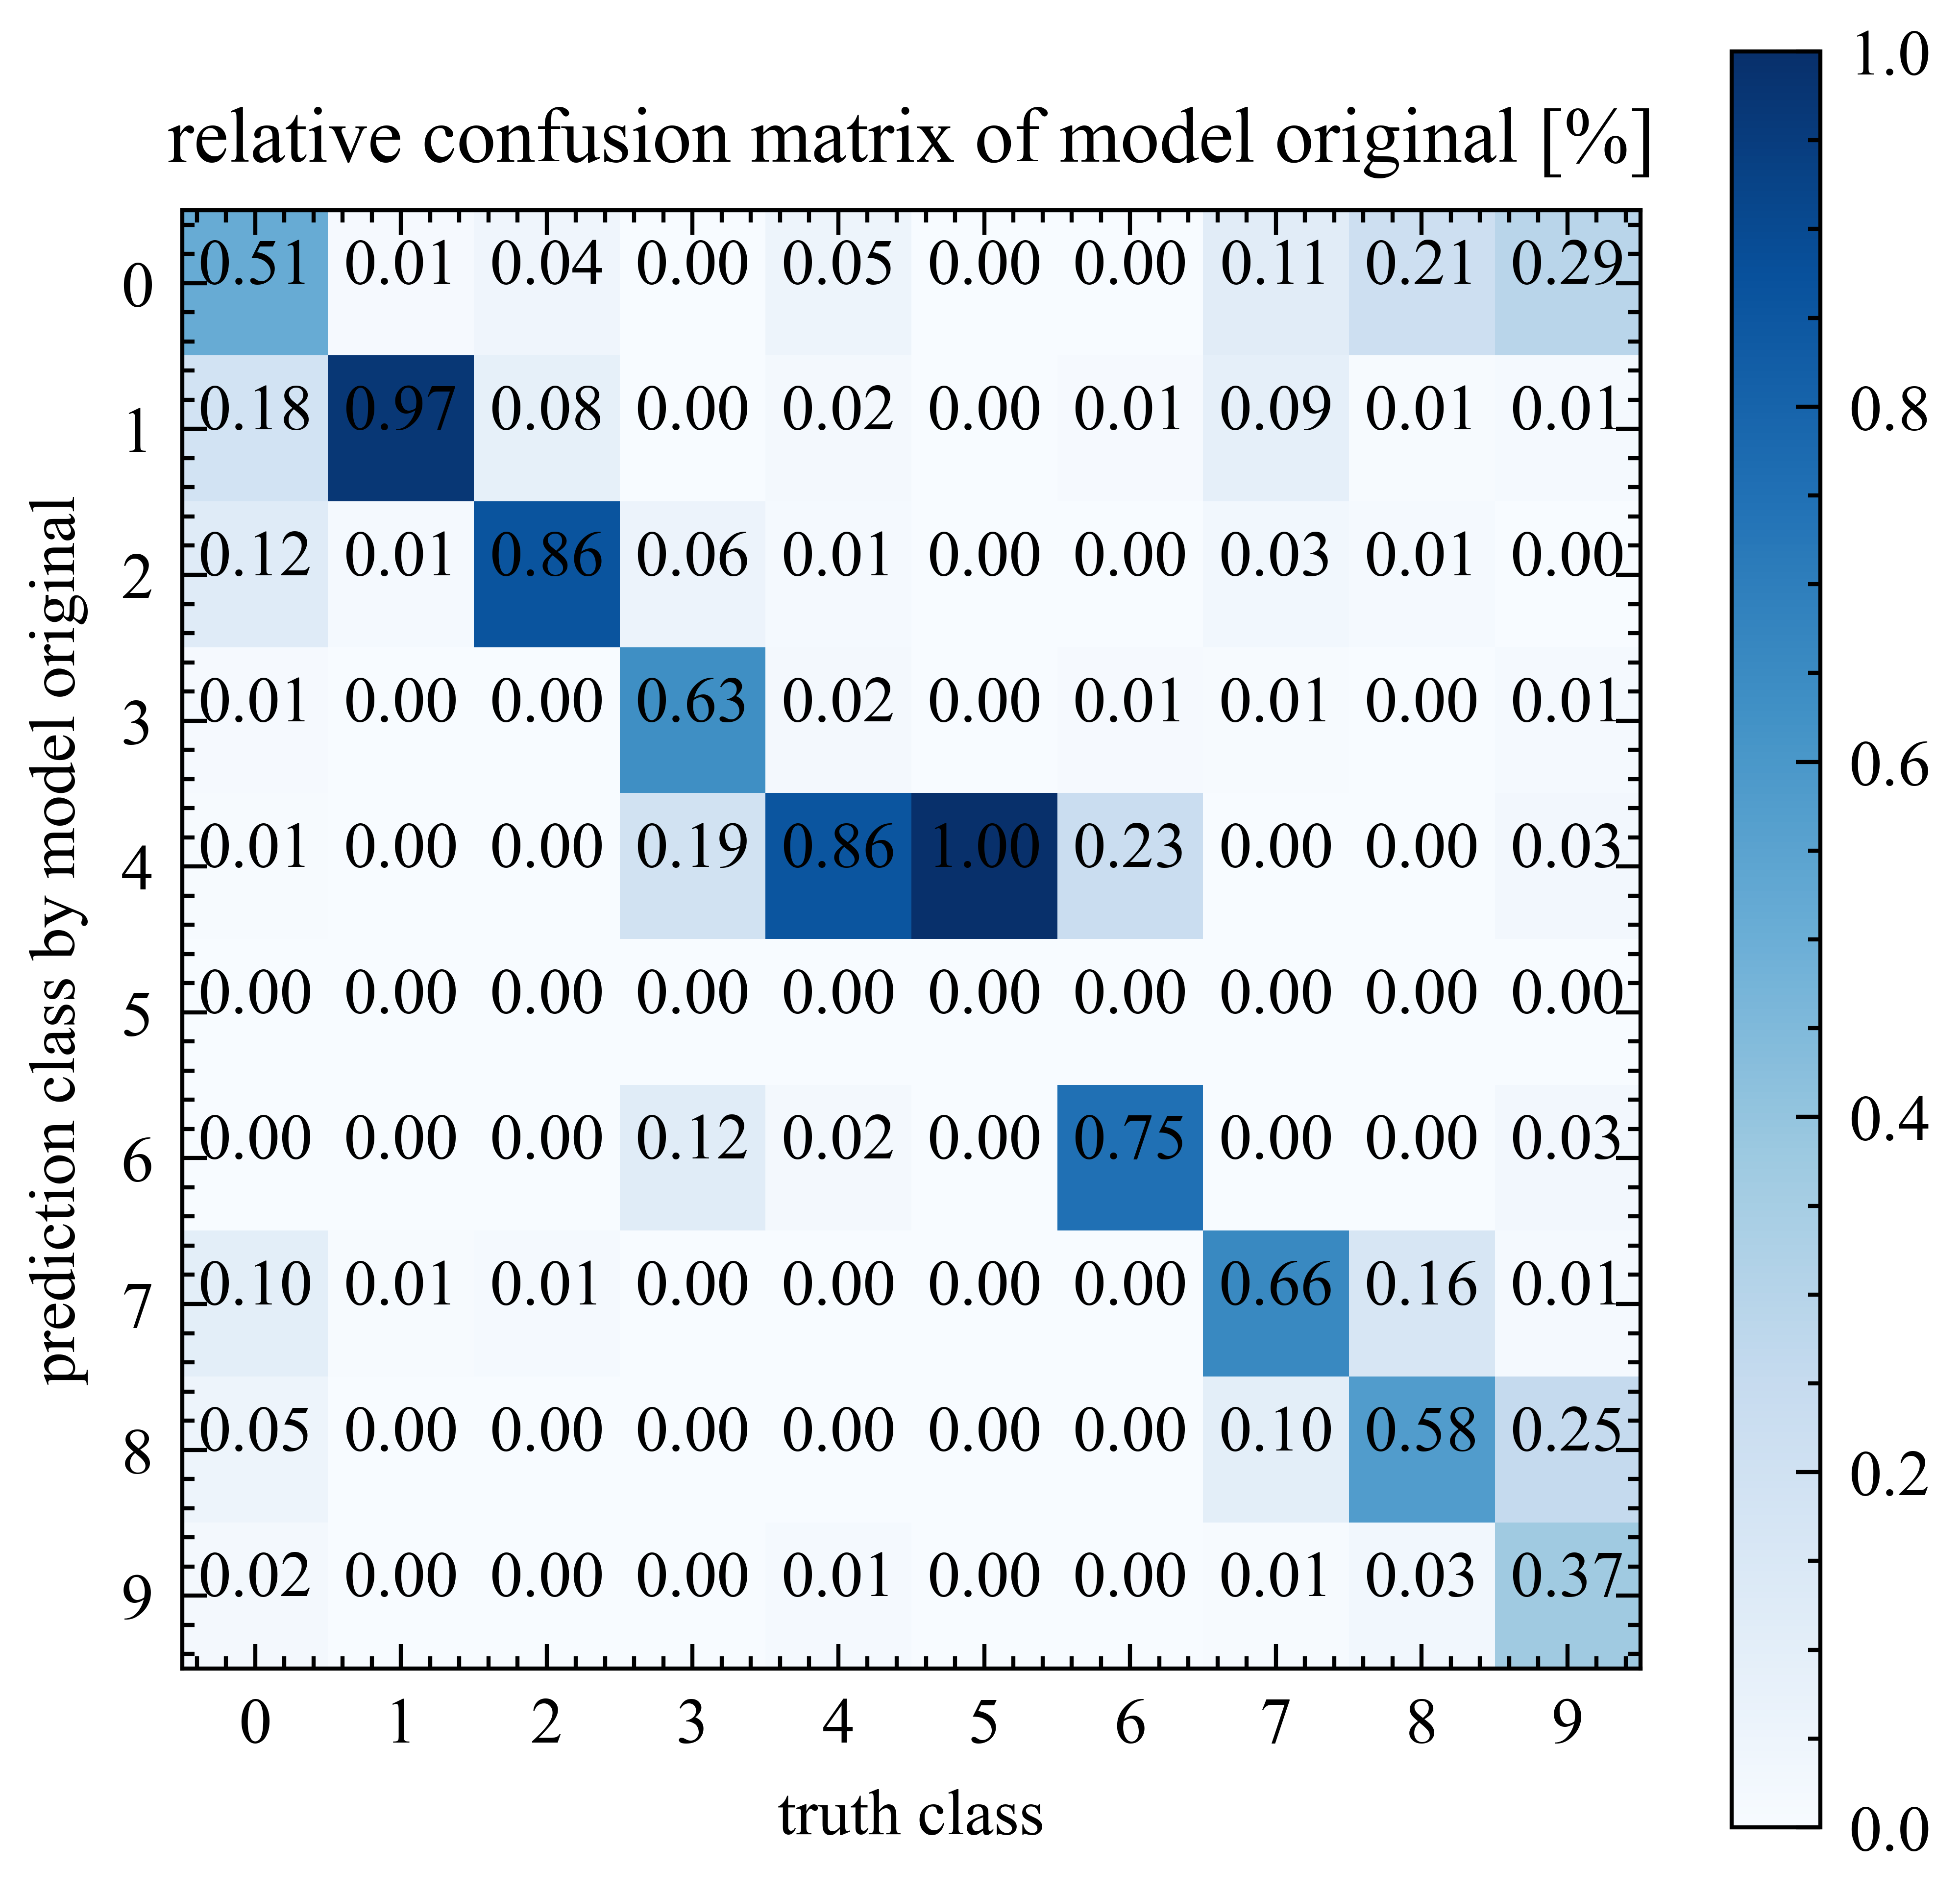

In [199]:
plt.style.use(['science','ieee'])
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[4,4])

plt.imshow(confusion_matrix_per,interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

# 在每个色块上显示对应的数值
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix_per[i, j], '.2f'),
                 horizontalalignment="center",
                 color="black" if confusion_matrix_per[i, j] > 0.5 else "black")
plt.title('relative confusion matrix of model original [%]')
plt.ylabel('prediction class by model original')
plt.xlabel('truth class')

x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

In [200]:
#缩小网络规模 learningrate 1e-4
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

# 定义基本块
def basic_block(x, filters, stride=1):
    print("Input shape:", x.shape)
    shortcut = x

    # 第一个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 第二个卷积层
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果步幅不为 1，或输入和输出通道数不匹配，则需要对 shortcut 进行调整
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    print("Skip connection shape:", x.shape)

    # 添加 shortcut 到主路径上
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    print("Output shape:", x.shape)

    return x

# 定义 ResNet 结构
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # 堆叠残差块
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)

    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128, stride=1)
    x = basic_block(x, filters=128, stride=1)
    #x = basic_block(x, filters=128, stride=1)

    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256, stride=1)
    x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)
    #x = basic_block(x, filters=256, stride=1)

    x = basic_block(x, filters=512, stride=2)
    x = basic_block(x, filters=512, stride=1)
    #x = basic_block(x, filters=512, stride=1)

    # 全局平均池化
    x = GlobalAveragePooling2D()(x)

    # 全连接层 增加了两层
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def prepare_data(train_images, train_labels, test_images, test_labels):
    
    trlabels=np.zeros(train_labels.shape[0])
    telabels=np.zeros(test_labels.shape[0])
   
    for i in range(train_labels.shape[0]):
        trlabels[i]=np.argmax(train_labels[i])
    for i in range(test_labels.shape[0]):
        telabels[i]=np.argmax(test_labels[i])
    
    return trlabels,  telabels

# 模型训练
def train_model():
    input_shape = (69, 69, 3)
    num_classes = 10

    
    model = ResNet(input_shape, num_classes)
    optimizer = Adam(learning_rate=0.0001)

# 将优化器对象传入compile函数中
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    trlabels,  telabels=prepare_data(train_images, train_labels, test_images, test_labels)
    
    # 训练模型并保存每个epoch的模型
    for epoch in range(20):  # 假设训练10个epoch
        model.fit(train_images, trlabels, batch_size=64, epochs=1, validation_data=(test_images, telabels))
        model.save(f'resnet_models_sparse_lr/resnet_epoch_{epoch+1}.h5')

    #model.fit(train_images, trlabels, epochs=10, batch_size=32, validation_data=(test_images, telabels))

    return model



# 有没有模型
if not os.path.exists('resnet_models_sparse_lr'):
    os.makedirs('resnet_models_sparse_lr')



trained_model = train_model()



Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 18, 18, 64)
Output shape: (None, 18, 18, 64)
Input shape: (None, 18, 18, 64)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 9, 9, 128)
Output shape: (None, 9, 9, 128)
Input shape: (None, 9, 9, 128)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: (None, 5, 5, 256)
Output shape: (None, 5, 5, 256)
Input shape: (None, 5, 5, 256)
Skip connection shape: 